<h1>1. Business Problem</h1>

<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>
<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>
 
<h6> Context:</h6>
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462</p>

<h6> Problem statement : </h6>
<p> Classify the given genetic variations/mutations based on evidence from text-based clinical literature. </p>

<h2>1.2. Real-world/Business objectives and constraints.</h2>

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data Overview</h2>

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h6>training_variants</h6>
<hr>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>
...

<h6> training_text</h6>
<hr>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6). ... 

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>
    
            There are nine different classes a genetic mutation can be classified into => Multi class classification problem
   
      
    
</p>

<h3>2.2.2. Performance Metric</h3>

* Multi class log-loss 
* Confusion matrix 


<h3>2.2.3. Machine Learing Objectives and Constraints</h3>

<p> Objective: Predict the probability of each data-point belonging to each of the nine classes.
</p>
<p> Constraints:
</p>

* Interpretability

* Class probabilities are needed.

* Penalize the errors in class probabilites => Metric is Log-loss.

* No Latency constraints.

<h1>3. Exploratory Data Analysis</h1>

In [2]:
# first things first , importing basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from sklearn.preprocessing import normalize
import math
warnings.filterwarnings("ignore")
# Libs for Data cleaning
import re
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss, confusion_matrix

# models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB


# metrics
from sklearn.metrics import log_loss, accuracy_score

### 3.1 Reading Gene and Variation Data 

In [3]:
data_gene = pd.read_csv("train data/training_variants")

print("Number of datapoints : ", data_gene.shape[0])
print("Number of columns : ", data_gene.shape[1])
print("Columns name : ", ", ".join(data_gene.columns))

data_gene.head()

Number of datapoints :  3321
Number of columns :  4
Columns name :  ID, Gene, Variation, Class


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


   Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

### 3.2 Reading Text Data 

In [4]:
data_text = pd.read_csv("train data/training_text", sep="\|\|",names=["ID","TEXT"],skiprows=1)
print("Number of datapoints : ", data_text.shape[0])
print("Number of columns : ", data_text.shape[1])
print("Columns name : ", ", ".join(data_text.columns))
data_text.head()

Number of datapoints :  3321
Number of columns :  2
Columns name :  ID, TEXT


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### 3.3 Data Preprocessing/ Data Cleaning

In [5]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))
stop_words.remove("not")
stop_words.remove("no")




def clean(text):
    
    if type(text) == str:
        sentence = text.lower()
        # Replacing each special character with blank space
        sentence = re.sub(r"[^a-zA-Z0-9\n\s]"," ", sentence)
        # replacing doubles space with single space
        sentence = re.sub(r"\s+", " ", sentence)

        sentence = ' '.join(word for word in sentence.split() if word not in stop_words)
        return sentence
    else:
        return text
    
    
    
    

In [6]:
start_time = time.clock()

data_text["TEXT"] = data_text["TEXT"].apply(clean)

print("Time required for cleaning : ", (time.clock()- start_time)," seconds")

Time required for cleaning :  27.264038600000006  seconds


In [7]:
# merging both gene_variations and text data based on ID

data = pd.merge(data_gene, data_text, on="ID", how="left")
data.head()


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
data[data.isnull().any(1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [9]:
# Replacing nan values with gene + variation value
data.TEXT[data.isnull().any(1)] = data.Gene[data.isnull().any(1)] + data.Variation[data.isnull().any(1)]

<h3>3.4. Test, Train and Cross Validation Split</h3>

In [10]:
data.Gene = data.Gene.str.replace("\s+","_")
data.Variation = data.Variation.str.replace("\s+","_")

# Splitting data into Independent and dependent vraibles
X = data[["Gene", "Variation", "TEXT","Class"]]
y = data.iloc[:,3].values

# Splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=0)

# Splitting data into train and cross validate data
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train, stratify=y_train, test_size=0.2, random_state=0)


<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [11]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>3.4.1. Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

In [13]:
# Distribution of data
def distribution_data(y,target):
    
    print("*"*30,"Bar Plot for {} data".format(target),"*"*30)
    print()
    class_count = pd.Series(y).value_counts()

    for i in class_count.keys(): 
        print("Number of points in class {} : {} ({})%".format( i,class_count[i] ,np.round(class_count[i]*100/len(y),3)))

    #class_count.sort_index().plot(kind="bar")
    plt.figure(figsize=(10,7))
    g= sns.barplot(np.sort(class_count.keys()),class_count.sort_index())
    
    # For adding Values Over bar
    #https://github.com/mwaskom/seaborn/issues/1582
    for p,i in list(zip(g.patches,range(1,10))):
        g.annotate(format(f"{p.get_height()} ({np.round(class_count[i]*100/len(y),2)}%)"), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    plt.xlabel('Class')
    plt.ylabel('Data points per Class')
    plt.title('Distribution of yi in {} data'.format(target))
    plt.grid()
    plt.show()


****************************** Bar Plot for Train data ******************************

Number of points in class 7 : 609 (28.672)%
Number of points in class 4 : 439 (20.669)%
Number of points in class 1 : 363 (17.09)%
Number of points in class 2 : 289 (13.606)%
Number of points in class 6 : 176 (8.286)%
Number of points in class 5 : 155 (7.298)%
Number of points in class 3 : 57 (2.684)%
Number of points in class 9 : 24 (1.13)%
Number of points in class 8 : 12 (0.565)%


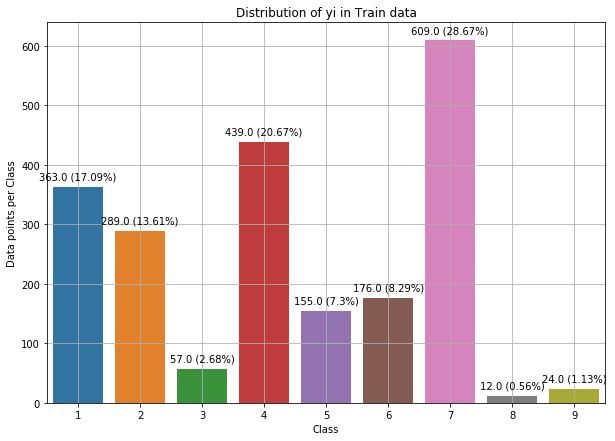

****************************** Bar Plot for Test data ******************************

Number of points in class 7 : 191 (28.722)%
Number of points in class 4 : 137 (20.602)%
Number of points in class 1 : 114 (17.143)%
Number of points in class 2 : 91 (13.684)%
Number of points in class 6 : 55 (8.271)%
Number of points in class 5 : 48 (7.218)%
Number of points in class 3 : 18 (2.707)%
Number of points in class 9 : 7 (1.053)%
Number of points in class 8 : 4 (0.602)%


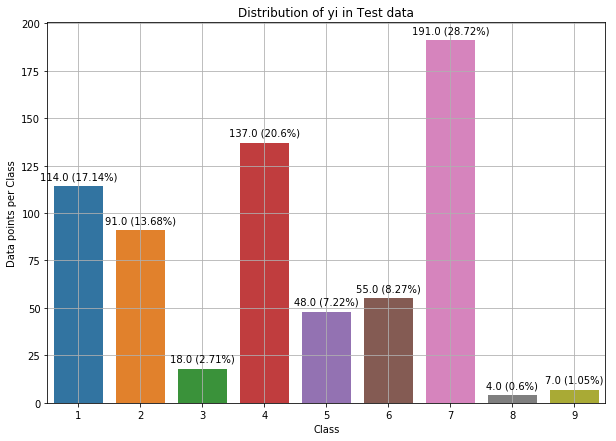

****************************** Bar Plot for C.V data ******************************

Number of points in class 7 : 153 (28.759)%
Number of points in class 4 : 110 (20.677)%
Number of points in class 1 : 91 (17.105)%
Number of points in class 2 : 72 (13.534)%
Number of points in class 6 : 44 (8.271)%
Number of points in class 5 : 39 (7.331)%
Number of points in class 3 : 14 (2.632)%
Number of points in class 9 : 6 (1.128)%
Number of points in class 8 : 3 (0.564)%


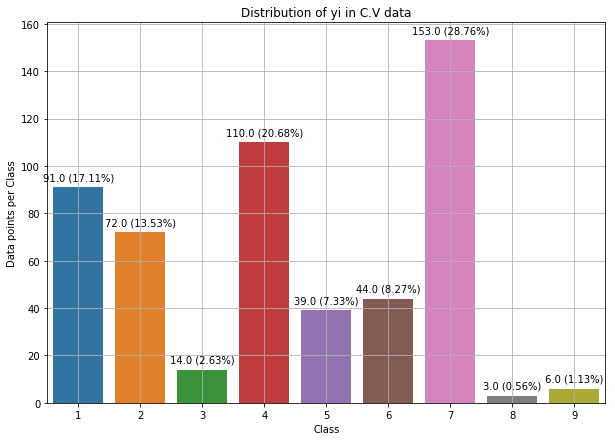

In [711]:
# Plotting ditribution for each dataset


distribution_data(y_train, "Train")
distribution_data(y_test, "Test")
distribution_data(y_cv, "C.V")

Observation:

We can observe that

1] The data for each class label has same or almost equal distribution, which is good coz if distribution is different the
model may not work properly

2] Data is Imbalanced data.

<h2>3.5 Prediction using a 'Random' Model</h2>

In [236]:
# Function for plotting Confusion matrix
def plot_confusion_matrix(y_true,y_pred):
    
    # Confusion matrix
    c = confusion_matrix(y_true, y_pred)
    
    labels = [1,2,3,4,5,6,7,8,9]
    #plotting Confusion Matrix
    plt.figure(figsize=(20,7))
    print("*"*50,"COnfusion Matrix","*"*50)
    sns.heatmap(c, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Plotting Precision Matrix
    plt.figure(figsize=(20,7))
    print("*"*50,"Precision Matrix","*"*50)
    a = c/(np.sum(c,axis=0))
    sns.heatmap(a, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Precision Matrix")
    plt.show()
    
    # Plotting Recall Matrix
    plt.figure(figsize=(20,7))
    print("*"*50,"Recall Matrix","*"*50)
    b = (c.T/np.sum(c, axis=1)).T
    sns.heatmap(b, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.title("Recall Matrix")
    plt.show()
    

Log loss for CV Data :  2.442608201434795
Log loss for Train Data :  2.463862093254123
The Worst log loss for this Use Case one model can get is :  2.4532351473444587
************************************************** COnfusion Matrix **************************************************


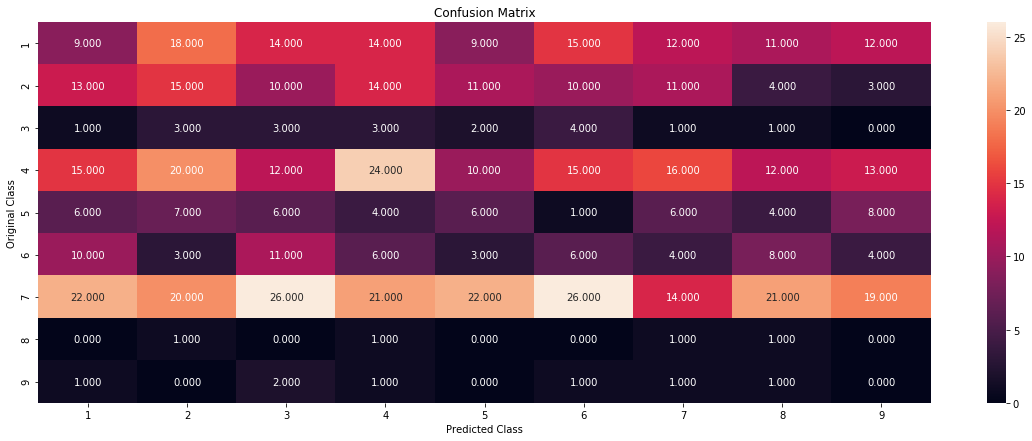

************************************************** Precision Matrix **************************************************


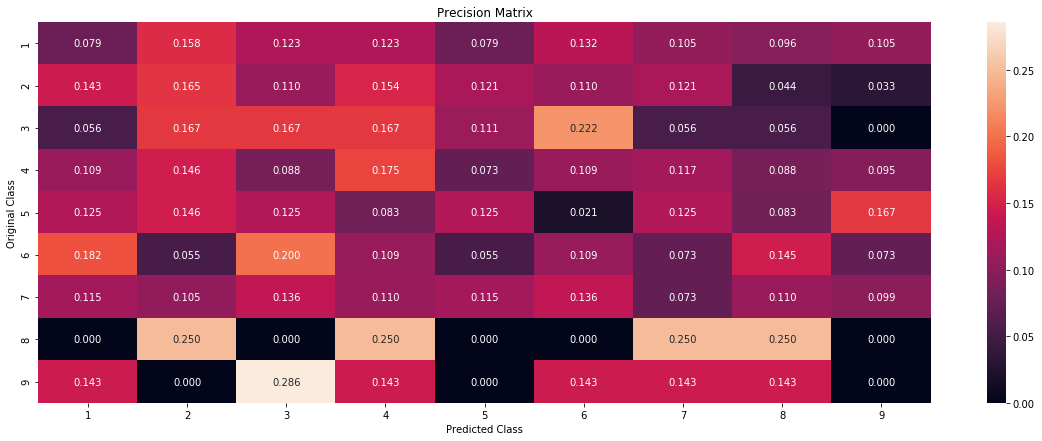

************************************************** Recall Matrix **************************************************


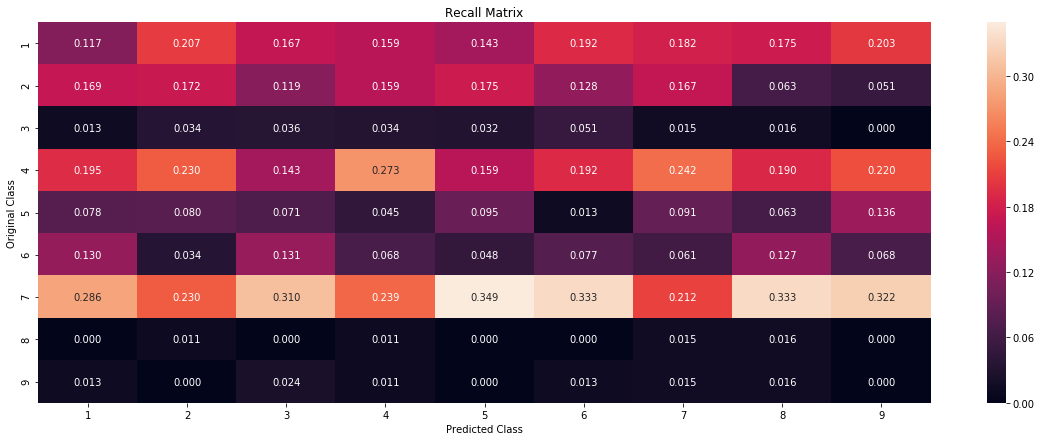

In [713]:
# Random Model

# Cross Validate Data for Random model
cv_data = np.zeros((len(y_cv), 9))

for i in range(0,len(y_cv)):
    random_value = np.random.rand(1,9)
    prob_class = (random_value/np.sum(random_value))
    cv_data[i] = prob_class

# Test Data for Random model
test_data = np.zeros((len(y_test), 9))

for i in range(0,len(y_test)):
    random_value = np.random.rand(1,9)
    prob_class = (random_value/np.sum(random_value))
    test_data[i] = prob_class

# Printing log loss on CV and Test data
print("Log loss for CV Data : ", log_loss(y_cv, cv_data))
print("Log loss for Train Data : ", log_loss(y_test, test_data))

# Printing Benchmark Logloss
print("The Worst log loss for this Use Case one model can get is : ",(log_loss(y_cv, cv_data)+log_loss(y_test, test_data))/2)

# printing confusion Matrix

y_pred = test_data.argmax(axis=1)
plot_confusion_matrix(y_test, y_pred+1)

<h3 style="color:red">Key Take Away from Confusion Matrix is the worst performance of dumb model can be ~ 2.5(log_loss)

## 3.6 Univariate Analysis of Gene Feature : 

Number of unique gene's or categories in Train Data  226

Distribution of each category:
 BRCA1    169
TP53     101
EGFR      94
PTEN      85
BRCA2     77
KIT       59
BRAF      58
ERBB2     46
ALK       41
FGFR2     40
Name: Gene, dtype: int64


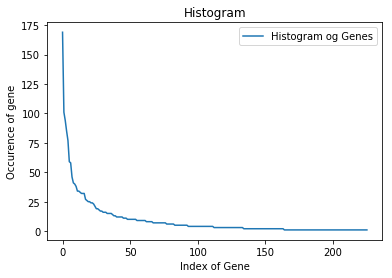

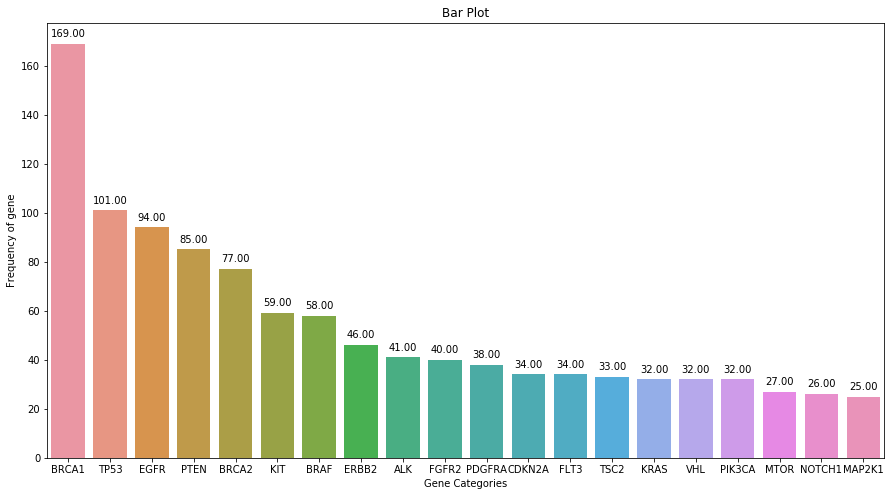

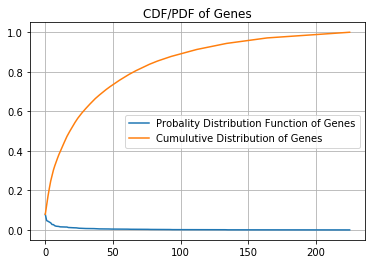

In [60]:
"""
Q.1] What type of Feature is Gene:
->   Gene is Categorical Feature.

Q.2] How many unique categories are in Gene & how are they distributed?
"""

unique_gene_count = X_train.Gene.value_counts()

print("Number of unique gene's or categories in Train Data ", len(unique_gene_count))

print("\nDistribution of each category:\n",unique_gene_count.head(10))

# Histogram plot of gene
plt.plot(unique_gene_count.values, label="Histogram og Genes")
plt.xlabel("Index of Gene")
plt.ylabel("Occurence of gene")
plt.title("Histogram")
plt.legend()
plt.show()

# Bar plot of gene of top 10 categories
plt.figure(figsize=(15,8))
g=sns.barplot(x =unique_gene_count.index[:20] ,y=unique_gene_count.values[:20])
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel("Gene Categories")
plt.ylabel("Frequency of gene")
plt.title("Bar Plot")
plt.show()

# CDF
pdf  = unique_gene_count.values/ sum(unique_gene_count.values)
c = np.cumsum(pdf)
plt.plot(pdf,  label="Probality Distribution Function of Genes")
plt.plot(c,  label="Cumulutive Distribution of Genes")
plt.grid()
plt.title("CDF/PDF of Genes")
plt.legend()
plt.show()


Observations -

1] From Histogram we can conclude that very few categories have higher frequency while mojority of them occure fe number of time. And the higtogram is also right skwed.

2] Bar plot also confirms the same that only the top few most have higher frequecny while other have low count.

3] From cdf we can say that top 100 categories contiribute to 90% of data, while pdf is alsoright skwed

4] Each Plot Confirms same one thing that amongst all gene ctaegories only top few contribute considerably

### 3.6.1] Feature Transformation of Gene Feature 

<p style="font-size:18px;"><b>Q3</b>. How to featurize this Gene feature ?</p>
<p style="font-size:13px;"><b>Ans.</b> The two ways as per number of categories we can featurize this variable:
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression, Linear SVM while response coding is better for Random Forests, XGBoost</p>

#### One hot Encoding 

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

gene_vectorizer = CountVectorizer()
gene_vectorizer.fit(X_train.Gene)

train_gene_onehot_encoding = gene_vectorizer.transform(X_train.Gene)
test_gene_onehot_encoding = gene_vectorizer.transform(X_test.Gene)
cv_gene_onehot_encoding = gene_vectorizer.transform(X_cv.Gene)

In [14]:
print("Number of rows after one hot encoding for train data : ",train_gene_onehot_encoding.shape[1])
print("Number of rows after one hot encoding for test data : ",test_gene_onehot_encoding.shape[1])
print("Number of rows after one hot encoding for cv data : ",cv_gene_onehot_encoding.shape[1])

Number of rows after one hot encoding for train data :  225
Number of rows after one hot encoding for test data :  225
Number of rows after one hot encoding for cv data :  225


#### Response Encoding

Let me explain in brief whats gonna happen in below code. Basically For each category of any feature , I am gonna replace it 
with vector of len 9 as we have 9 classes, such that each value in vector will represent the probablity of it with each class.

In [214]:
# Function for getting probablity of each categroy with each class
def get_probablity(alpha, feature, df):
    
    
    counts = df[feature].value_counts()
    category_probablity = dict()
    
    for category , frequency in counts.items():
        
        category_prob = []
        
        for i in range(1,10):
            
            category_len = len(df[(df["Class"] == i) & (df[feature] == category)])
            
            probablity = (category_len+alpha*10)/(frequency+alpha*90)
            
            category_prob.append(probablity)
            
        category_probablity[category] = category_prob
    
    return category_probablity
        
       
def get_encoded_features(alpha, feature, df):
    
    category_probablity = get_probablity(alpha, feature, df)
    
    counts = df[feature].value_counts()
    
    response_encoded_features = pd.DataFrame(columns=[str(x)+"_Prob" for x in range(1,10)])
    
    for index, row in df.iterrows():
        if row[feature] in category_probablity:
            values = dict(zip( [str(x)+"_Prob" for x in range(1,10)], category_probablity[row[feature]]  ))
            response_encoded_features = response_encoded_features.append(values, ignore_index=True)
        else:
            values = dict(zip( [str(x)+"_Prob" for x in range(1,10)], [1/9 for x in range(1,10)]  ))
            response_encoded_features = response_encoded_features.append(values, ignore_index=True)
    
    return response_encoded_features


In [215]:
# Encoding Each dataset

train_gene_response_encoding = get_encoded_features(1, "Gene", X_train)
test_gene_response_encoding = get_encoded_features(1, "Gene", X_test)
cv_gene_response_encoding = get_encoded_features(1, "Gene", X_cv)

In [216]:
print("Shape of Encoded train data: ", train_gene_response_encoding.shape)
print("Shape of Encoded test data: ", test_gene_response_encoding.shape)
print("Shape of Encoded cv data: ", cv_gene_response_encoding.shape)

Shape of Encoded train data:  (2124, 9)
Shape of Encoded test data:  (665, 9)
Shape of Encoded cv data:  (532, 9)


### 3.6.2] Analysing Importance and Stability of Gene feature 

<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For alpha 1e-05 log_loss is 1.3870468447618116
For alpha 0.0001 log_loss is 1.2159741721811521
For alpha 0.001 log_loss is 1.240949911737416
For alpha 0.01 log_loss is 1.3471077827397941
For alpha 0.1 log_loss is 1.4655295368185326
For alpha 1 log_loss is 1.5070498610818235
For alpha 10 log_loss is 1.5124402866411697


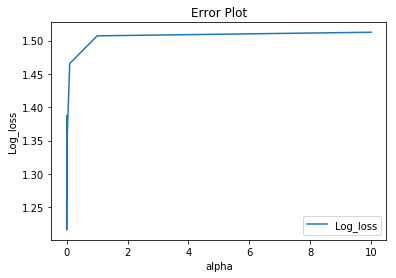

Best alpha:  0.0001
 Log_loss on Test Data :  1.1824833977922369
 Log_loss on CV Data :  1.2159741721811521
 Log_loss on Train Data :  1.0505172190473846


In [861]:
# Building Logistic model

alpha = [10**x for x in range(-5,2)]
error = []

for i in alpha:
    sgd = SGDClassifier(alpha=i, loss="log", penalty="l2", random_state=42)
    sgd.fit(train_gene_onehot_encoding, y_train)
    clf = CalibratedClassifierCV(sgd,method="sigmoid")
    clf.fit(train_gene_onehot_encoding, y_train)
    
    predict = clf.predict_proba(cv_gene_onehot_encoding)
    loss = log_loss(y_cv, predict)
    error.append(loss)
    print("For alpha {} log_loss is {}".format(i , loss))
    
best_alpha = alpha[error.index(min(error))]

# Plotting Error 
plt.plot(alpha, error, label="Log_loss")
plt.xlabel("alpha")
plt.ylabel("Log_loss")
plt.title("Error Plot")
plt.legend()
plt.show()

print("Best alpha: ", best_alpha)
# Training Model with best alpha
sgd = SGDClassifier(alpha=best_alpha, loss="log", penalty="l2", random_state=42)
sgd.fit(train_gene_onehot_encoding, y_train)
clf = CalibratedClassifierCV(sgd,method="sigmoid")
clf.fit(train_gene_onehot_encoding, y_train)

# Predicting on Test data
y_pred = clf.predict_proba(test_gene_onehot_encoding)
test_loss = log_loss(y_test, y_pred)
print(" Log_loss on Test Data : ", test_loss)

# Predicting on CV data
y_pred = clf.predict_proba(cv_gene_onehot_encoding)
cv_loss = log_loss(y_cv, y_pred)
print(" Log_loss on CV Data : ", cv_loss)

# Predicting on Train data
y_pred = clf.predict_proba(train_gene_onehot_encoding)
train_loss = log_loss(y_train, y_pred)
print(" Log_loss on Train Data : ", train_loss)

    
    
    

### Observation on Gene Feature:
    
 1] The log_loss of train, test and cv data doesnt differ much, hence model is not overfitting<br>
 
 2] The log_loss using "Gene" feature is <b>1.18</b> on test data, while the log_loss of worst model is <b>~2.5</b>,
 which indicates that "Gene" impacts majorly for prediction as tha log loss is reduced drastically if only gene is used to predict Class.
  
******************************************************************************************************************

<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [890]:
print("Q6. How many data points in Test and CV datasets are covered by the", X_train["Gene"].value_counts().shape[0], "genes in train dataset?")

test = X_test[X_test.Gene.isin(list(set(X_train["Gene"])))].shape[0]
cv = X_cv[X_cv.Gene.isin(list(set(X_train["Gene"])))].shape[0]

print("Out of {} pts the test data covers {} ({}f%) pts".format(X_test.shape[0], test, (test/len(X_test))*100))
print("Out of {} pts the cv  data covers {} ({}%) pts".format(X_cv.shape[0], cv, (cv/len(X_cv))*100))



Q6. How many data points in Test and CV datasets are covered by the 226 genes in train dataset?
Out of 665 pts the test data covers 643 (96.69172932330827f%) pts
Out of 532 pts the cv  data covers 508 (95.48872180451127%) pts


<h3>Final Conclusion on Gene Feature:
<br><br>

Hence we can conclude that <span style="color:red"> Gene is an Important Feature</span> and must be used for prediction purpose.
</h3>

## 3.7] Univariate Analysis of Variation Feature 

In [124]:
"""
Q.1] What type of Feature is Variation:
->   Variation is Categorical Feature.

Q.2] How many unique categories are in Gene & how are they distributed?
"""

unique_variation_count = X_train.Variation.value_counts()

print("Number of unique gene's or categories in Train Data ", len(unique_variation_count))

print("\nDistribution of each category:\n",unique_variation_count.head(10))

Number of unique gene's or categories in Train Data  1929

Distribution of each category:
 Truncating_Mutations    55
Amplification           48
Deletion                44
Fusions                 27
G12V                     3
T167A                    2
K117N                    2
P34R                     2
F384L                    2
R841K                    2
Name: Variation, dtype: int64


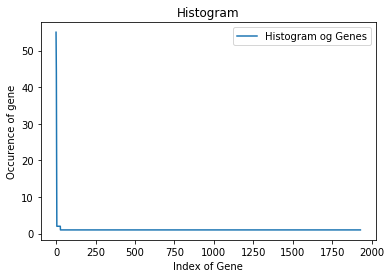

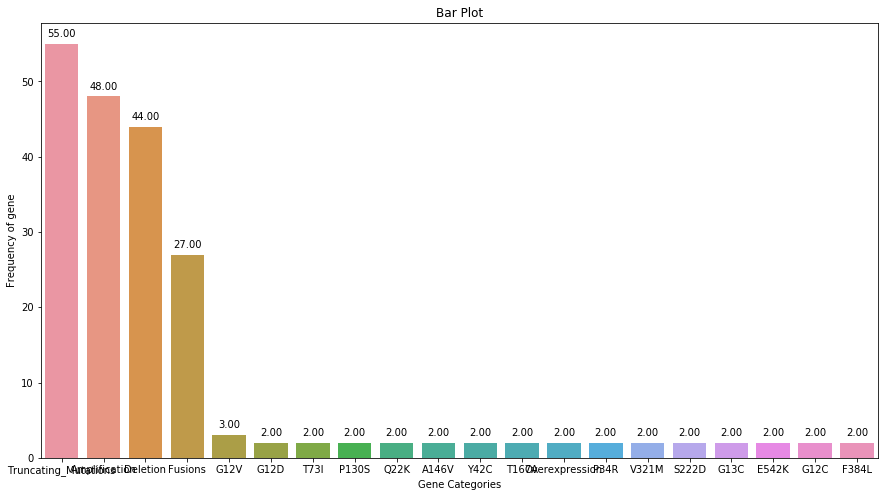

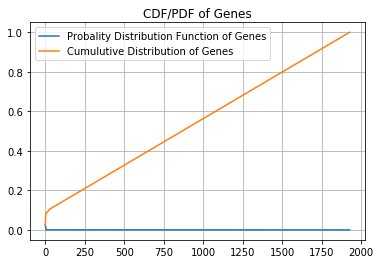

In [879]:
# Histogram plot of gene
plt.plot(unique_variation_count.values, label="Histogram og Genes")
plt.xlabel("Index of Gene")
plt.ylabel("Occurence of gene")
plt.title("Histogram")
plt.legend()
plt.show()

# Bar plot of gene of top 10 categories
plt.figure(figsize=(15,8))
g=sns.barplot(x =unique_variation_count.index[:20] ,y=unique_variation_count.values[:20])
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel("Gene Categories")
plt.ylabel("Frequency of gene")
plt.title("Bar Plot")
plt.show()

# CDF
pdf  = unique_variation_count.values/ sum(unique_variation_count.values)
c = np.cumsum(pdf)
plt.plot(pdf,  label="Probality Distribution Function of Genes")
plt.plot(c,  label="Cumulutive Distribution of Genes")
plt.grid()
plt.title("CDF/PDF of Genes")
plt.legend()
plt.show()

Observations -

1] From Histogram we can conclude that very few categories have higher frequency while majority of them occure very few number of times like once or twice. And the higtogram is also right skwed.

2] Bar plot also confirms the same that only the top few most have higher frequecny while other have very very low count.

3] From cdf we can say that top 1500 categories contiribute to 80% of data, while pdf is also right skwed

4] Each Plot Confirms same one thing that amongst all variation ctaegories only top few contribute considerably while others contribution is poor

### 3.7.1] Feature Transformation of Variation Feature 

<p style="font-size:18px;"><b>Q3</b>. How to featurize this Variation feature ?</p>
<p style="font-size:13px;"><b>Ans.</b> The two ways as per number of categories we can featurize this variable:
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression, Linear SVM while response coding is better for Random Forests, XGBoost</p>

#### One hot Encoding 

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

variation_vectorizer = CountVectorizer()
variation_vectorizer.fit(X_train.Variation)

train_variation_onehot_encoding = variation_vectorizer.transform(X_train.Variation)
test_variation_onehot_encoding = variation_vectorizer.transform(X_test.Variation)
cv_variation_onehot_encoding = variation_vectorizer.transform(X_cv.Variation)

print("Number of rows after one hot encoding for train data : ",train_variation_onehot_encoding.shape[1])
print("Number of rows after one hot encoding for test data : ",test_variation_onehot_encoding.shape[1])
print("Number of rows after one hot encoding for cv data : ",cv_variation_onehot_encoding.shape[1])

Number of rows after one hot encoding for train data :  1956
Number of rows after one hot encoding for test data :  1956
Number of rows after one hot encoding for cv data :  1956


#### Response Encoding

In [217]:
# Encoding Each dataset

train_variation_response_encoding = get_encoded_features(1, "Variation", X_train)
test_variation_response_encoding = get_encoded_features(1, "Variation", X_test)
cv_variation_response_encoding = get_encoded_features(1, "Variation", X_cv)

print("Shape of Encoded train data: ", train_variation_response_encoding.shape)
print("Shape of Encoded test data: ", test_variation_response_encoding.shape)
print("Shape of Encoded cv data: ", cv_variation_response_encoding.shape)

Shape of Encoded train data:  (2124, 9)
Shape of Encoded test data:  (665, 9)
Shape of Encoded cv data:  (532, 9)


### 3.7.2] Analysing Importance and Stability of Variation feature 

<p style="font-size:18px;"> <b>Q4.</b> How good is this variation feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For alpha 1e-05 log_loss is 1.7183183219047198
For alpha 0.0001 log_loss is 1.7055971679720234
For alpha 0.001 log_loss is 1.7031780233150433
For alpha 0.01 log_loss is 1.7097248043870967
For alpha 0.1 log_loss is 1.7163869593445384
For alpha 1 log_loss is 1.7192762227537035
For alpha 10 log_loss is 1.7196511139833464


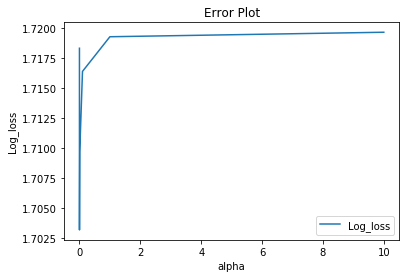

Best alpha:  0.001
 Log_loss on Test Data :  1.708692905946978
 Log_loss on CV Data :  1.7031780233150433
 Log_loss on Train Data :  1.068803879314985


In [886]:
# Building Logistic model

alpha = [10**x for x in range(-5,2)]
error = []

for i in alpha:
    sgd = SGDClassifier(alpha=i, loss="log", penalty="l2", random_state=42)
    sgd.fit(train_variation_onehot_encoding, y_train)
    clf = CalibratedClassifierCV(sgd,method="sigmoid")
    clf.fit(train_variation_onehot_encoding, y_train)
    
    predict = clf.predict_proba(cv_variation_onehot_encoding)
    loss = log_loss(y_cv, predict)
    error.append(loss)
    print("For alpha {} log_loss is {}".format(i , loss))
    
best_alpha = alpha[error.index(min(error))]

# Plotting Error 
plt.plot(alpha, error, label="Log_loss")
plt.xlabel("alpha")
plt.ylabel("Log_loss")
plt.title("Error Plot")
plt.legend()
plt.show()

print("Best alpha: ", best_alpha)
# Training Model with best alpha
sgd = SGDClassifier(alpha=best_alpha, loss="log", penalty="l2", random_state=42)
sgd.fit(train_variation_onehot_encoding, y_train)
clf = CalibratedClassifierCV(sgd,method="sigmoid")
clf.fit(train_variation_onehot_encoding, y_train)

# Predicting on Test data
y_pred = clf.predict_proba(test_variation_onehot_encoding)
test_loss = log_loss(y_test, y_pred)
print(" Log_loss on Test Data : ", test_loss)

# Predicting on CV data
y_pred = clf.predict_proba(cv_variation_onehot_encoding)
cv_loss = log_loss(y_cv, y_pred)
print(" Log_loss on CV Data : ", cv_loss)

# Predicting on Train data
y_pred = clf.predict_proba(train_variation_onehot_encoding)
train_loss = log_loss(y_train, y_pred)
print(" Log_loss on Train Data : ", train_loss)  

### Observation on Variation Feature:
    
 1] The log_loss of train, test and cv data differs slightly, hence model is not overfitting, but telling us that the data can be unstable, and the reson is as we know only 4,5 categories have considerable count while others occur twice or once hence chance of each category goin into all thre datasets is less, and hence the data of all three might not overlap considerbaly or may overlap very slightly , Hence this is the reason why the log loss differs<br>
 
 2] The log_loss using "Variation" feature is <b>1.06</b> on test data, while the log_loss of worst model is <b>~2.5</b>,
 which indicates that "Variation" impacts majorly for prediction as the log loss is reduced drastically if only variation is used to predict Class.
 
 3] It may reduce the log loss considerably but we are not sure how stable the data is actually.
  
******************************************************************************************************************

<p style="font-size:18px;"> <b>Q5.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not Sure, lets check. </p>

In [889]:
print("Q6. How many data points in Test and CV datasets are covered by the", X_train["Variation"].value_counts().shape[0], "variation in train dataset?")

test = X_test[X_test.Variation.isin(list(set(X_train["Variation"])))].shape[0]
cv = X_cv[X_cv.Variation.isin(list(set(X_train["Variation"])))].shape[0]

print("Out of {} pts the test data covers {} ({}%) pts".format(X_test.shape[0], test, (test/len(X_test))*100))
print("Out of {} pts the cv  data covers {} ({}%) pts".format(X_cv.shape[0], cv, (cv/len(X_cv))*100))

Q6. How many data points in Test and CV datasets are covered by the 1929 variation in train dataset?
Out of 665 pts the test data covers 76 (11.428571428571429%) pts
Out of 532 pts the cv  data covers 51 (9.586466165413533%) pts


Observation:

1] We found that variation data is unstable because of less frequency of major datapts.

2] We also found that variation reduces the log_loss considerably even the data is unstable.
    

<h3>Final Conclusion on Variation Feature:
<br><br>

Hence we can conclude that <span style="color:red"> Variation is an Important Feature</span> and must be used for prediction purpose even though its unstable
</h3>

## 3.8 ] Univariate Analysis of Text Feature 

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [17]:
# Answering unique words question
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52867


In [37]:
# Answering Question 2

words_df = pd.DataFrame([list(text_fea_dict.keys()),list(text_fea_dict.values())], index=["keys", "values"]).T

print(dict(words_df["values"].value_counts()))


{3: 4883, 4: 3770, 5: 3157, 6: 3015, 9: 2120, 8: 1806, 7: 1682, 10: 1473, 12: 1390, 11: 1087, 15: 979, 14: 858, 13: 811, 18: 795, 16: 689, 17: 627, 20: 559, 22: 528, 24: 485, 19: 440, 21: 438, 27: 430, 30: 396, 25: 369, 23: 363, 28: 346, 38: 342, 29: 307, 31: 306, 26: 306, 35: 293, 36: 289, 34: 268, 46: 265, 32: 257, 33: 236, 40: 228, 42: 217, 37: 213, 39: 200, 45: 198, 48: 190, 47: 176, 41: 171, 44: 169, 51: 165, 56: 164, 60: 161, 43: 160, 54: 158, 52: 153, 49: 152, 50: 149, 57: 136, 53: 131, 55: 129, 63: 127, 59: 121, 66: 116, 68: 116, 58: 113, 61: 112, 70: 110, 69: 108, 64: 104, 67: 100, 84: 99, 72: 92, 62: 88, 76: 87, 65: 87, 78: 86, 92: 85, 75: 83, 80: 82, 87: 82, 77: 80, 71: 78, 107: 74, 73: 73, 79: 73, 90: 72, 89: 72, 91: 67, 82: 66, 81: 65, 74: 65, 106: 62, 83: 62, 103: 62, 85: 61, 100: 61, 105: 61, 98: 60, 102: 58, 88: 56, 86: 55, 120: 53, 113: 53, 93: 53, 95: 53, 110: 52, 97: 52, 96: 51, 112: 51, 108: 50, 115: 48, 94: 48, 121: 47, 126: 46, 109: 45, 118: 44, 130: 44, 150: 44, 

We can read above dictionary as follows:

1] There are 4883 words which have occured 3 times in corpus.

2] There are 3770 words which have occured 4 times in corpus, and etc.


In [1043]:
# Checking which word has occured the most
words_df.sort_values(by="values", ascending=0)[:10]

,keys,values
33238,mutations,151532
12081,cells,118106
12070,cell,81117
20445,fig,67429
33221,mutation,66619
19245,et,66536
6904,al,66385
34781,not,66355
11257,cancer,61688
20453,figure,61668


As we can see the most occured value in our courpus is mutations cells, and is floowed by cells, cell, fig, mutation etc

### 3.8.1] Feature Transformation of Text Feature 

#### One Hot Encoding 

In [18]:
# don't forget to normalize every feature
train_text_onehot_encoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_onehot_encoding = text_vectorizer.transform(X_test['TEXT'])
# don't forget to normalize every feature
test_text_onehot_encoding = normalize(test_text_onehot_encoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_onehot_encoding = text_vectorizer.transform(X_cv['TEXT'])
# don't forget to normalize every feature
cv_text_onehot_encoding = normalize(cv_text_onehot_encoding, axis=0)

In [19]:
train_text_onehot_encoding.shape

(2124, 52867)

#### Response Encoding 

In [41]:
from tqdm import tqdm_notebook as tqdm 
word_names = train_text_features
word_count_dict = text_fea_dict

word_probablity_dict = dict()


for word in tqdm(word_names):
    probablity = []
    for i in range(1,10):
        count = 0
        for index, row in X_train[:10].iterrows():
            text = row["TEXT"].split()
            
            if word in text and row.Class == i:
                count +=1
        if count:
            total_count = word_count_dict.get(word)
            prob = (count +10)/(total_count+90)
            probablity.append(prob)
        else:
            probablity.append(1/9)
    
    probablity = np.array(probablity)
    
    word_probablity_dict[word] = probablity
    

The above code crates a dictionary of each word and itsb probablity with each class ex-
{ word : [1,2,3,4,5,6,7,8,9] }, where numbers represent its probablity with respective class.

In [57]:
word_probablity_dict["000"]

array([0.11111111, 0.00191371, 0.11111111, 0.11111111, 0.00191371,
       0.11111111, 0.00208768, 0.11111111, 0.11111111])

In [1234]:
word_names

['00',
 '000',
 '0000',
 '0000001',
 '000001',
 '000002',
 '000003',
 '000007',
 '000009',
 '00001',
 '000011',
 '000012',
 '000017',
 '00002644',
 '00003',
 '000038',
 '00005',
 '000059',
 '00006',
 '000077',
 '00008',
 '00009',
 '0001',
 '000132',
 '00014',
 '000141',
 '00016',
 '000179',
 '000182',
 '0001a',
 '0002',
 '0002158',
 '000245',
 '000249',
 '00025',
 '000251',
 '000258',
 '000264',
 '000267',
 '00028',
 '00029',
 '0003',
 '000369266',
 '00037',
 '0004',
 '0005',
 '000535',
 '000548',
 '000588',
 '0006',
 '0007',
 '0008',
 '00088',
 '0009',
 '000g',
 '000xg',
 '001',
 '0010',
 '0011',
 '001198',
 '0012',
 '001210',
 '001269551',
 '0012a',
 '0013',
 '0014',
 '001429',
 '0014b',
 '0015',
 '0016',
 '001635',
 '001654',
 '001664',
 '0017',
 '0018',
 '001810',
 '0019',
 '001987',
 '001a',
 '001acd4',
 '001acd8',
 '001bathe',
 '001bimmunophenotypecd34',
 '001blyl1',
 '002',
 '0021',
 '0022',
 '0023',
 '0024',
 '0025',
 '0025021',
 '0026',
 '002648',
 '0026a',
 '0027',
 '002755',

In [1266]:
from tqdm import tqdm_notebook as tqdm
def text_response_encoding(df):
    
    sentence_probablity = []
    
    for sentence in tqdm(df["TEXT"]):
        text = sentence.split()
        
        text_prob = np.zeros((1, 9))
        
        for word in text:
            if word in word_names:
                probablity = word_probablity_dict.get(word)
                log_probablity = [math.log(x) for x in probablity]
                text_prob += log_probablity
            else:
                probablity = [math.log(1/9) for x in range(9)]
                text_prob += probablity
        
        text_prob = text_prob/len(sentence)
        text_log_prob = np.array([math.exp(x) for x in text_prob[0]])
        sentence_probablity.append(text_log_prob)
        
    return np.array(sentence_probablity)
                
            

In [1303]:
# reponse encoding of text feature

train_response_encoding = text_response_encoding(X_train)

In [1264]:
(train_response_encoding.T/train_response_encoding.sum(axis=1)).sum(axis=0)

array([1., 1.])

In [ ]:
test_response_encoding = normalize(text_response_encoding(X_test))

cv_response_encoding = normalize(text_response_encoding(X_cv))

In [209]:
from collections import Counter, defaultdict
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(X_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [211]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(X_train)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(X_cv)

In [212]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

### 3.8.2] Analysing Importance and Stability of Text feature 

Log_loss for alpha 1e-05 is 1.356688310918447
Log_loss for alpha 0.0001 is 1.3093118793671386
Log_loss for alpha 0.001 is 1.1829101068233285
Log_loss for alpha 0.01 is 1.2402483521026753
Log_loss for alpha 0.1 is 1.4000924159545403
Log_loss for alpha 1 is 1.6359238183175515
Log_loss for alpha 10 is 1.6693695896624685


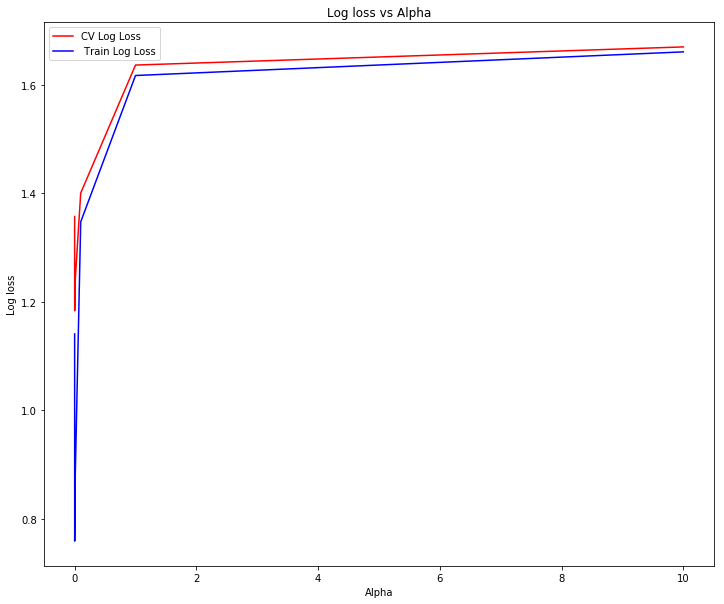

The best alpha is : 0.001
Log loss on Test data is :  1.196399087617159
Log loss on CV data is :  1.1829101068233285
Log loss on Train data is :  0.7584339099245088


In [1280]:
alpha = [10**x for x in range(-5,2)]

error =[]
train_error = []
for i in alpha:
    sgd = SGDClassifier(alpha=i, penalty="l2", loss="log",random_state=42)
    sgd.fit(train_text_onehot_encoding, y_train)
    clf = CalibratedClassifierCV(sgd, method = "sigmoid")
    clf.fit(train_text_onehot_encoding, y_train)
    
    # predicting on cv data
    pred = clf.predict_proba(cv_text_onehot_encoding)
    loss = log_loss(y_cv, pred)
    error.append(loss)
    print("Log_loss for alpha {} is {}".format(i, loss))
    
    # predicting on train data
    pred = clf.predict_proba(train_text_onehot_encoding)
    loss = log_loss(y_train, pred)
    train_error.append(loss)
    
# plotting error
plt.figure(figsize=(12,10))
plt.plot(alpha, error, "r",label="CV Log Loss")
plt.plot(alpha, train_error, "b",label=" Train Log Loss")
plt.xlabel("Alpha")
plt.ylabel("Log loss")
plt.title("Log loss vs Alpha")
plt.legend()
plt.show()

# best alpha
best_alpha = alpha[error.index(min(error))]

print("The best alpha is :", best_alpha)
# Training Model with best alpha

sgd = SGDClassifier(alpha = best_alpha, loss="log", penalty="l2", random_state=42)
sgd.fit(train_text_onehot_encoding, y_train)
clf = CalibratedClassifierCV(sgd, method="sigmoid")
clf.fit(train_text_onehot_encoding, y_train)

# Predicting on test data
pred = clf.predict_proba(test_text_onehot_encoding)
loss = log_loss(y_test, pred)
print("Log loss on Test data is : ", loss)

# Predicting on cv data
pred = clf.predict_proba(cv_text_onehot_encoding)
loss = log_loss(y_cv, pred)
print("Log loss on CV data is : ", loss)

# Predicting on train data
pred = clf.predict_proba(train_text_onehot_encoding)
loss = log_loss(y_train, pred)
print("Log loss on Train data is : ", loss)

### Observation on Text Feature:
    
 1] The log_loss of train, test and cv data doesnt differ much, hence model is not overfitting<br>
 
 2] The log_loss using "Text" feature is <b>1.19</b> on test data, while the log_loss of worst model is <b>~2.5</b>,
 which indicates that "Text" impacts majorly for prediction as tha log loss is reduced drastically if only Text is used to predict Class.
  
******************************************************************************************************************

<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [1300]:
count_vectorizer = CountVectorizer(min_df=3)
count_vectorizer.fit_transform(X_test.TEXT)
test_word_names = set(count_vectorizer.get_feature_names())

count_vectorizer.fit_transform(X_cv.TEXT)
cv_word_names = set(count_vectorizer.get_feature_names())

print("Number of words common in train and test : ", len(set(word_names).intersection(test_word_names)))
print("i.e {} % of test data appeared in train data".format(len(set(word_names) & test_word_names)*100/len(test_word_names)))

print("Number of words common in cv and test : ", len(set(word_names) & cv_word_names))
print("i.e {} % of cv data appeared in train data".format(len(set(word_names) & cv_word_names)*100/len(cv_word_names)))

Number of words common in train and test :  28841
i.e 96.30680869536181 % of test data appeared in train data
Number of words common in cv and test :  24763
i.e 98.81090140058258 % of cv data appeared in train data


Observation-

Text data is stable as the above number says so.

<h3>Final Conclusion on Text Feature:
<br><br>

Hence we can conclude that <span style="color:red"> Text is an Important Feature</span> and must be used for prediction purpose.
</h3>

Feature Importance :-

1] Text feature is first most imp feature.

2] After Text, Gene feature importance is high.

3] And third most important feature is Variation.

## 4 ] Machine Learning Models 

### 4.1 ] Preparing data for models

#### Tf-idf for Text feature 

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=3)

train_text_vectorizer = vectorizer.fit_transform(X_train.TEXT)

train_text_vectorizer = normalize(train_text_vectorizer , axis=0)

test_text_vectorizer = vectorizer.transform(X_test.TEXT)

test_text_vectorizer =normalize(test_text_vectorizer , axis=0)

cv_text_vectorizer = vectorizer.transform(X_cv.TEXT)
cv_text_vectorizer = normalize(cv_text_vectorizer , axis=0)

### Stacking Gene , Variation and Text Features

In [33]:
#del #cv_gene_onehot_encoding, cv_variation_onehot_encoding, cv_text_vectorizer#train_gene_onehot_encoding, test_gene_onehot_encoding, train_variation_onehot_encoding, test_variation_onehot_encoding

In [178]:
# stacking gene and variation and text one hot encoded features

train_gv_onehot_encoding = np.hstack([train_gene_onehot_encoding.toarray(), train_variation_onehot_encoding.toarray()])

train_final_onehot_encoding = np.hstack([train_gv_onehot_encoding, train_text_vectorizer.toarray()])

test_gv_onehot_encoding = np.hstack([test_gene_onehot_encoding.toarray(), test_variation_onehot_encoding.toarray()])
test_final_onehot_encoding = np.hstack([test_gv_onehot_encoding, test_text_vectorizer.toarray()])

cv_gv_onehot_encoding = np.hstack([cv_gene_onehot_encoding.toarray(), cv_variation_onehot_encoding.toarray()])
cv_final_onehot_encoding = np.hstack([cv_gv_onehot_encoding, cv_text_vectorizer.toarray()])

In [221]:
# stacking gene, variation, text rresponse encoded features

train_gv_response_encoding = np.hstack([train_gene_response_encoding, train_variation_response_encoding])
train_final_response_encoding = np.hstack([train_gv_response_encoding, train_text_feature_responseCoding])

test_gv_response_encoding = np.hstack([test_gene_response_encoding, test_variation_response_encoding])
test_final_response_encoding = np.hstack([test_gv_response_encoding, test_text_feature_responseCoding])

cv_gv_response_encoding = np.hstack([cv_gene_response_encoding, cv_variation_response_encoding])
cv_final_response_encoding = np.hstack([cv_gv_response_encoding, cv_text_feature_responseCoding])

In [135]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [136]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

###  4.2 ] Naive Bayes Model

#### 4.2.1] HyperParameter Tuning 

Log loss for alpha 1e-05 is 1.280985908536013
Log loss for alpha 0.0001 is 1.2631351972237173
Log loss for alpha 0.001 is 1.265633245793278
Log loss for alpha 0.01 is 1.2631115617431046
Log loss for alpha 0.1 is 1.2581032481275787
Log loss for alpha 1 is 1.2963804828416192
Log loss for alpha 10 is 1.3820024004123728
Log loss for alpha 100 is 1.3009220104786072


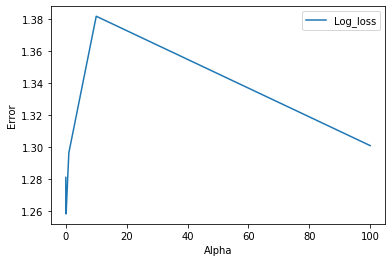

Best Alpha is  0.1


In [195]:
alpha = [10**x for x in range(-5, 3)]

error = []

for i in alpha:
    clf = MultinomialNB(alpha=i)
    loss = report_log_loss(train_final_onehot_encoding, y_train, cv_final_onehot_encoding, y_cv, clf)
    error.append(loss)
    print("Log loss for alpha {} is {}".format(i, loss))
    
# Plotting error
plt.plot(alpha, error, label="Log_loss")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.legend()
plt.show()

# Best Alpha 
best_alpha = alpha[error.index(min(error))]
print("Best Alpha is ", best_alpha)

#### 4.2.2] Training Naive Bayes Model with best Parameter

Log loss on test data is : 1.2732151550331372
39.0% of datapoint are mis_classified
************************************************** COnfusion Matrix **************************************************


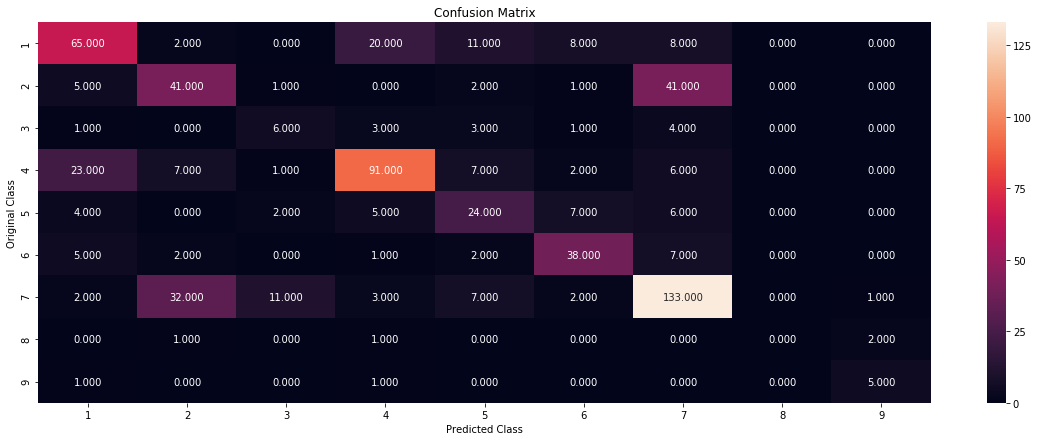

************************************************** Precision Matrix **************************************************


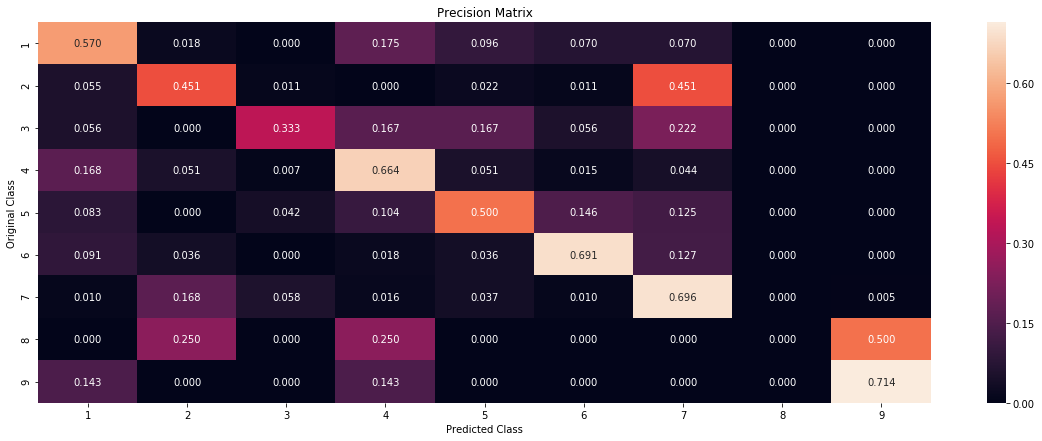

************************************************** Recall Matrix **************************************************


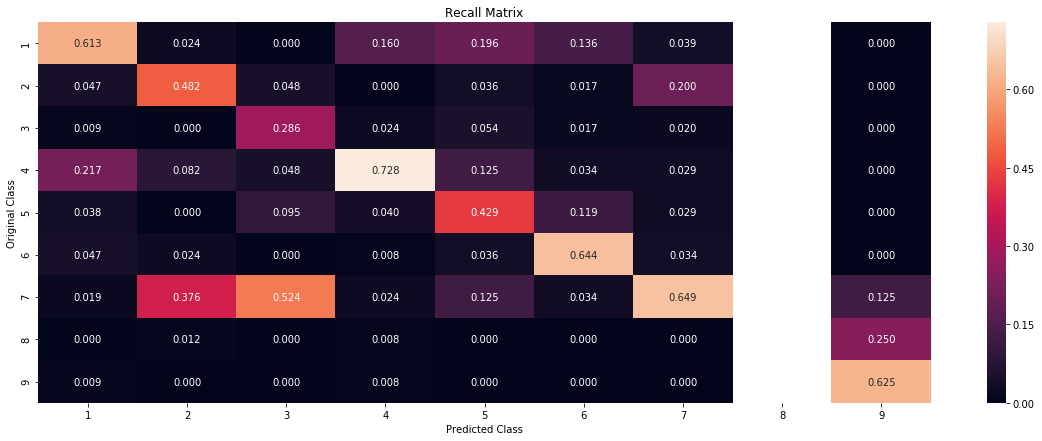

In [196]:
#Instantiating model
nb = MultinomialNB(alpha=best_alpha)
nb.fit(train_final_onehot_encoding, y_train)

clf = CalibratedClassifierCV(nb, method="sigmoid")
clf.fit(train_final_onehot_encoding, y_train)

# predicting on test class
pred = clf.predict(test_final_onehot_encoding)
pred_prob = clf.predict_proba(test_final_onehot_encoding)
loss = log_loss(y_test, pred_prob)

print("Log loss on test data is :", loss)

misclassified_points = np.count_nonzero((pred - y_test))/y_test.shape[0]#len(y_test)- len(set(pred) & set(y_test))
print("{}% of datapoint are mis_classified".format(np.round(misclassified_points*100),3))

plot_confusion_matrix(y_test, pred)

<h4>4.2.3] Feature Importance, Correctly classified point and Interpratablity using Query point</h4>

In [197]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    indices = list(indices)
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [206]:
test_point_index= 2
no_features =100

# Predicting test point
predicted_class = clf.predict(test_final_onehot_encoding[test_point_index].reshape(1,-1))[0]
predicted_prob = np.round(clf.predict_proba(test_final_onehot_encoding[test_point_index].reshape(1,-1)),4)
print("Predicted Class: ", predicted_class)
print("Predicted Probablities: ", predicted_prob)

# Getting actual class
actual_class = y_test[test_point_index]
print("Actual Class: ", actual_class)

indices = np.argsort(-nb.coef_)[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)



Predicted Class:  4
Predicted Probablities:  [[0.0921 0.0736 0.0164 0.4826 0.1717 0.0406 0.117  0.004  0.0021]]
Actual Class:  4
--------------------------------------------------
15 Text feature [cells] present in test data point [True]
16 Text feature [activated] present in test data point [True]
17 Text feature [downstream] present in test data point [True]
20 Text feature [cell] present in test data point [True]
21 Text feature [presence] present in test data point [True]
22 Text feature [kinase] present in test data point [True]
24 Text feature [activation] present in test data point [True]
25 Text feature [contrast] present in test data point [True]
26 Text feature [shown] present in test data point [True]
27 Text feature [phosphorylation] present in test data point [True]
28 Text feature [growth] present in test data point [True]
30 Text feature [not] present in test data point [True]
32 Text feature [however] present in test data point [True]
33 Text feature [also] present in t

<h4>4.2.4] Feature Importance, InCorrectly classified point and Interpratablity using Query point</h4>

In [205]:
test_point_index= 1
no_features =100

# Predicting test point
predicted_class = clf.predict(test_final_onehot_encoding[test_point_index].reshape(1,-1))[0]
predicted_prob = np.round(clf.predict_proba(test_final_onehot_encoding[test_point_index].reshape(1,-1)),4)
print("Predicted Class: ", predicted_class)
print("Predicted Probablities: ", predicted_prob)

# Getting actual class
actual_class = y_test[test_point_index]
print("Actual Class: ", actual_class)

indices = np.argsort(-nb.coef_)[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)



Predicted Class:  7
Predicted Probablities:  [[0.2618 0.078  0.0172 0.1185 0.0393 0.0427 0.43   0.0044 0.0081]]
Actual Class:  6
--------------------------------------------------
15 Text feature [cells] present in test data point [True]
16 Text feature [activated] present in test data point [True]
17 Text feature [downstream] present in test data point [True]
20 Text feature [cell] present in test data point [True]
21 Text feature [presence] present in test data point [True]
23 Text feature [factor] present in test data point [True]
24 Text feature [activation] present in test data point [True]
25 Text feature [contrast] present in test data point [True]
26 Text feature [shown] present in test data point [True]
27 Text feature [phosphorylation] present in test data point [True]
28 Text feature [growth] present in test data point [True]
29 Text feature [inhibitor] present in test data point [True]
30 Text feature [not] present in test data point [True]
31 Text feature [expressing] pres

###  4.3 ] Knn Model

#### 4.3.1] HyperParameter Tuning 

In [219]:
from sklearn.neighbors import KNeighborsClassifier

Log loss for n_neigbors 2 is 0.8386358765311931
Log loss for n_neigbors 3 is 0.8244428337823378
Log loss for n_neigbors 5 is 0.8524981124769605
Log loss for n_neigbors 7 is 0.8689217480919501
Log loss for n_neigbors 10 is 0.9048679326132529
Log loss for n_neigbors 13 is 0.9405808564737425
Log loss for n_neigbors 15 is 0.9464444503322152
Log loss for n_neigbors 18 is 0.96311961705282
Log loss for n_neigbors 20 is 0.9664515859098104
Log loss for n_neigbors 31 is 0.9716844472028652


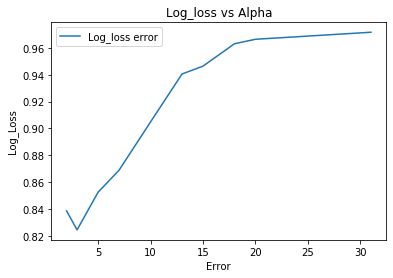

Best alpha is  3


In [227]:
alpha = [2,3,5, 7, 10, 13, 15, 18, 20, 31]

error = []

for i in alpha:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_final_response_encoding, y_train)
    clf = CalibratedClassifierCV(knn, method="sigmoid")
    clf.fit(train_final_response_encoding, y_train)
    
    pred = clf.predict_proba(cv_final_response_encoding)
    loss = log_loss(y_cv, pred)
    print("Log loss for n_neigbors {} is {}".format(i, loss))
    error.append(loss)
    
# Plotting error
plt.plot(alpha, error, label="Log_loss error")
plt.xlabel("Error")
plt.ylabel("Log_Loss")
plt.legend()
plt.title("Log_loss vs Alpha")
plt.show()

# Best alpha
best_alpha = alpha[error.index(min(error))]
print("Best alpha is ", best_alpha)


#### 4.3.2] Training Knn Model with best Parameter`

Log loss on test data is  0.8429665598378197
24.0602% of points are Miss Classified
************************************************** COnfusion Matrix **************************************************


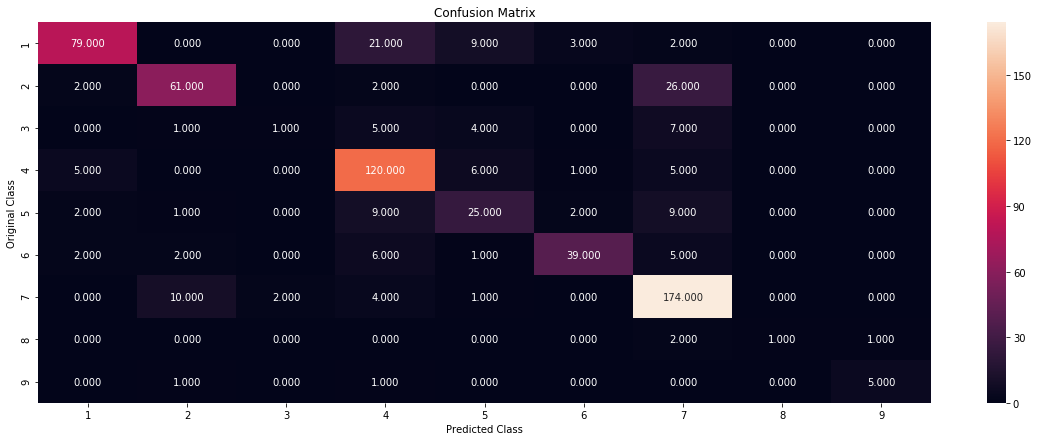

************************************************** Precision Matrix **************************************************


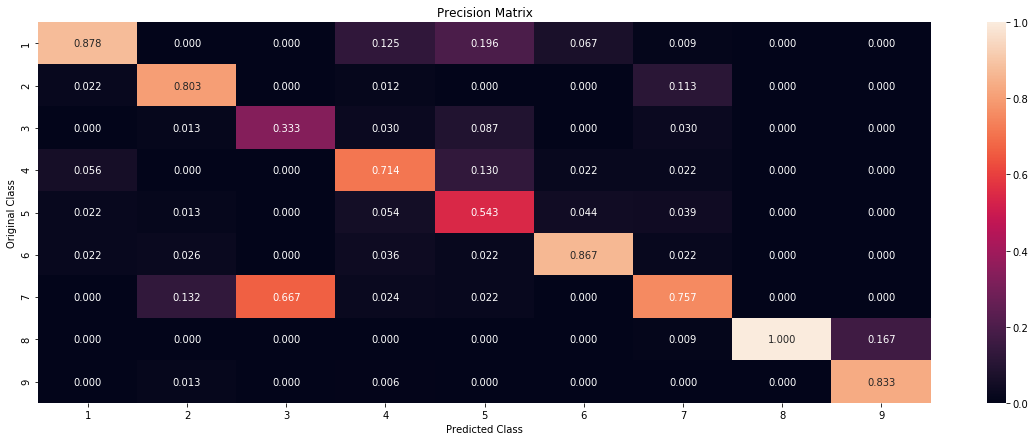

************************************************** Recall Matrix **************************************************


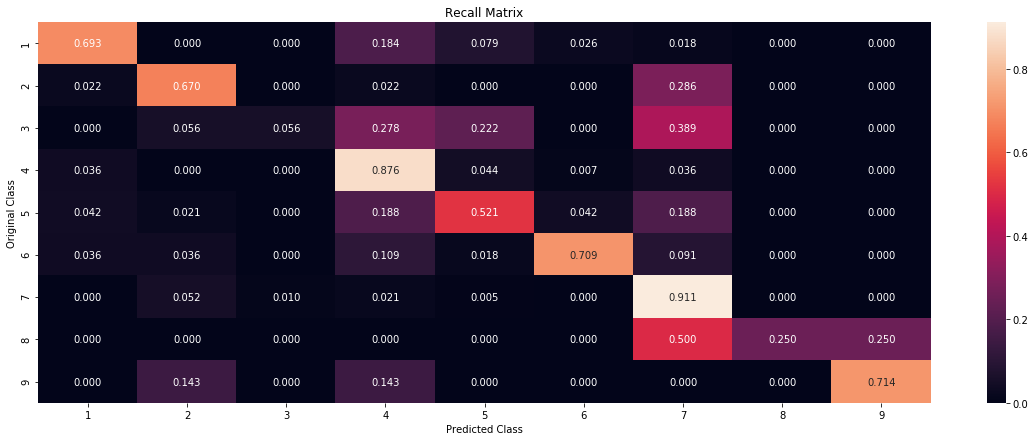

In [237]:
knn = KNeighborsClassifier(n_neighbors=best_alpha)
knn.fit(train_final_response_encoding, y_train)
clf = CalibratedClassifierCV(knn, method="sigmoid")
clf.fit(train_final_response_encoding, y_train)

# predicting on test data
pred = clf.predict(test_final_response_encoding)
pred_proba = clf.predict_proba(test_final_response_encoding)
loss = log_loss(y_test, pred_proba)
print("Log loss on test data is ", loss)

miss_classified_points = np.round(np.count_nonzero(y_test-pred)*100/len(y_test),4)

print("{}% of points are Miss Classified".format(miss_classified_points))
# Plotting confusion Matrix
plot_confusion_matrix(y_test, pred)

<h4>4.3.3] Sample Query point 1</h4>

In [296]:
test_index_point = 1

predicted_class = clf.predict(test_final_response_encoding[test_index_point].reshape(1,-1))[0]
nearest_neigh = y_train[knn.kneighbors(test_final_response_encoding[test_index_point].reshape(1,-1), best_alpha)[1][0]]
print("Predicted CLass : ", predicted_class)
print("Nearest Neighbors of Query Point : ",nearest_neigh)
print("Actual Class : ", y_test[test_index_point])
freq = pd.Series(nearest_neigh).value_counts()
print("Frequecy of class: " ,dict(zip(freq.index,freq.values)))

Predicted CLass :  7
Nearest Neighbors of Query Point :  [7 7 7]
Actual Class :  6
Frequecy of class:  {7: 3}


<h4>4.3.4] Sample Query point</h4>

In [302]:
test_index_point = 9

predicted_class = clf.predict(test_final_response_encoding[test_index_point].reshape(1,-1))[0]
nearest_neigh = y_train[knn.kneighbors(test_final_response_encoding[test_index_point].reshape(1,-1), best_alpha)[1][0]]
print("Predicted CLass : ", predicted_class)
print("Nearest Neighbors of Query Point : ",nearest_neigh)
print("Actual Class : ", y_test[test_index_point])
freq = pd.Series(nearest_neigh).value_counts()
print("Frequecy of class: " ,dict(zip(freq.index,freq.values)))

Predicted CLass :  3
Nearest Neighbors of Query Point :  [7 3 3]
Actual Class :  7
Frequecy of class:  {3: 2, 7: 1}


###  4.4 ] Logistic Regression Model with Class Balancing

<h4>4.4.1] Hyper-parameter tuning of model</h4>

log loss for alpha 1e-05 is 1.1967159745219833
log loss for alpha 0.0001 is 1.0506159043775232
log loss for alpha 0.001 is 1.0293090073474345
log loss for alpha 0.01 is 1.034842300008071
log loss for alpha 0.1 is 1.0672480442270693
log loss for alpha 1 is 1.250227413399415
log loss for alpha 10 is 1.2971515345216869
log loss for alpha 100 is 1.4192744792057401


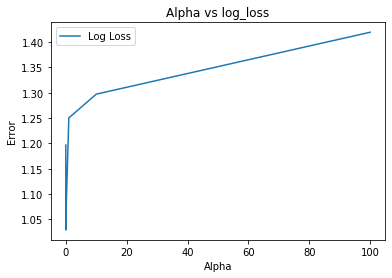

Best alpha is  0.001


In [304]:
alpha = [10**x for x in range(-5,3)]

error = []
for i in alpha:
    sgd = SGDClassifier(alpha=i, loss="log", penalty="l2", class_weight="balanced")
    sgd.fit(train_final_onehot_encoding, y_train)
    clf = CalibratedClassifierCV(sgd, method="sigmoid")
    clf.fit(train_final_onehot_encoding, y_train)

    pred = clf.predict_proba(cv_final_onehot_encoding)
    loss = log_loss(y_cv, pred)
    error.append(loss)
    print("log loss for alpha {} is {}".format(i,loss))
    

#Plotting log loss
plt.plot(alpha, error, label="Log Loss")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.title("Alpha vs log_loss")
plt.legend()
plt.show()

best_alpha = alpha[error.index(min(error))]
print("Best alpha is ", best_alpha)

<h4>4.4.2] Training model with best hyperparameter</h4>

Log Loss on Test data is : 1.2732151550331372
36.391% of points are miss-classified
************************************************** COnfusion Matrix **************************************************


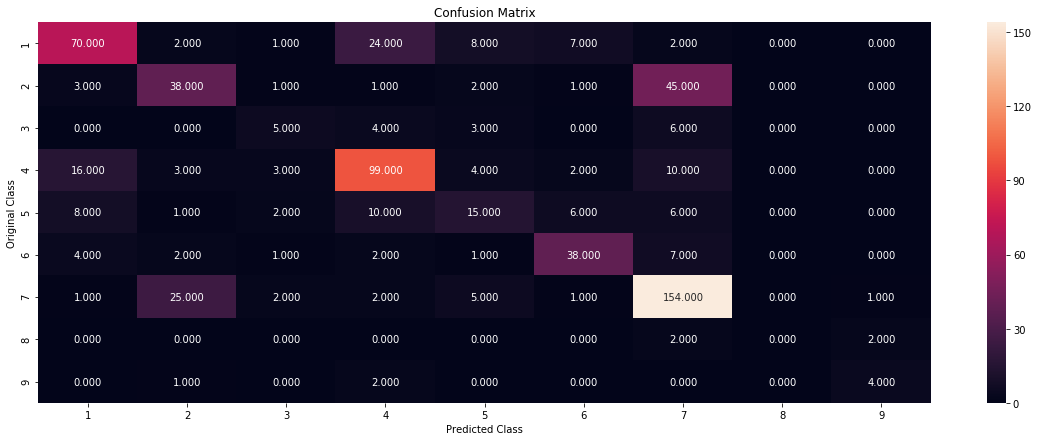

************************************************** Precision Matrix **************************************************


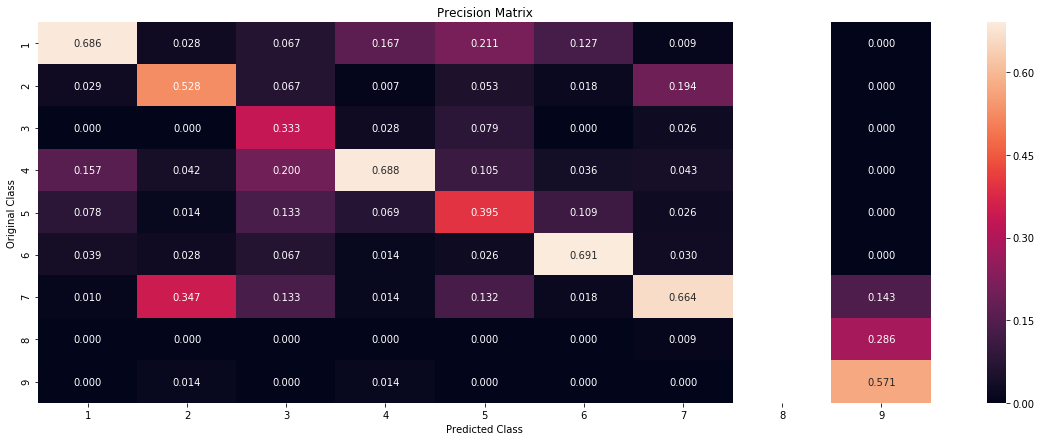

************************************************** Recall Matrix **************************************************


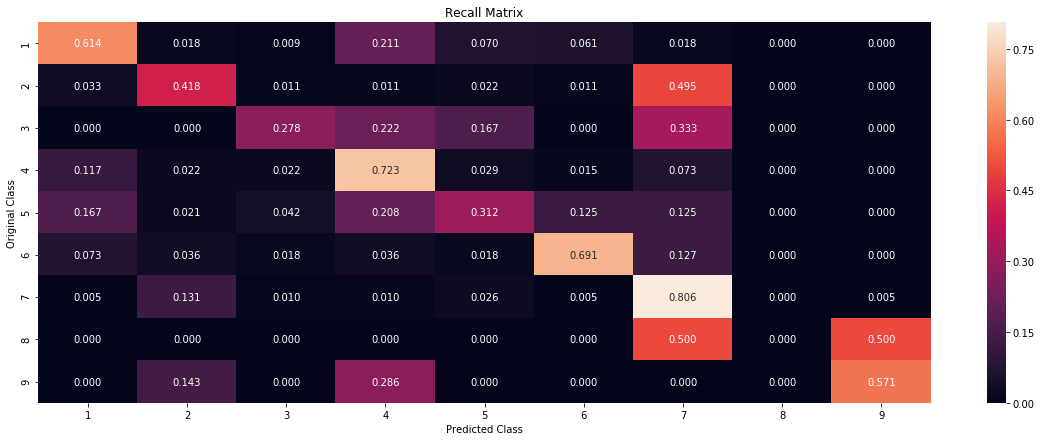

In [317]:
sgd = SGDClassifier(alpha=best_alpha, loss="log", penalty="l2", class_weight="balanced")
sgd.fit(train_final_onehot_encoding, y_train)
clf = CalibratedClassifierCV(sgd, method="sigmoid")
clf.fit(train_final_onehot_encoding, y_train)

# Predicting on test data
pred = clf.predict(test_final_onehot_encoding)
predict_prob = clf.predict_proba(test_final_onehot_encoding)
loss = log_loss(y_test, pred_prob)
miss_classified_points = np.round((np.count_nonzero(pred-y_test)*100/len(y_test)),4)

print("Log Loss on Test data is :", loss)
print("{}% of points are miss-classified".format(miss_classified_points))

plot_confusion_matrix(y_test, pred)

<h4>4.4.3] Feature Importance on correctly classified points</h4>

In [311]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [314]:
test_point_index = 4
no_feature = 500
predicted_cls = clf.predict(train_final_onehot_encoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(clf.predict_proba(test_final_onehot_encoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-sgd.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0065 0.0071 0.0043 0.9636 0.0055 0.0018 0.0051 0.0027 0.0034]]
Actual Class : 4
--------------------------------------------------
50 Text feature [suppressor] present in test data point [True]
57 Text feature [germline] present in test data point [True]
82 Text feature [tagged] present in test data point [True]
90 Text feature [come] present in test data point [True]
93 Text feature [hereditary] present in test data point [True]
107 Text feature [instability] present in test data point [True]
137 Text feature [localization] present in test data point [True]
138 Text feature [p15ink4b] present in test data point [True]
145 Text feature [hematopoiesis] present in test data point [True]
170 Text feature [analysed] present in test data point [True]
172 Text feature [triggering] present in test data point [True]
173 Text feature [subcellular] present in test data point [True]
174 Text feature [maintenance] present in test data point [T

<h4>4.4.4] Feature Importance on in-correctly classified points</h4>

In [316]:
test_point_index = 1
no_feature = 500
predicted_cls = clf.predict(train_final_onehot_encoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(clf.predict_proba(test_final_onehot_encoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-sgd.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0777 0.149  0.0123 0.1678 0.0214 0.0364 0.5245 0.0055 0.0054]]
Actual Class : 6
--------------------------------------------------
67 Text feature [continues] present in test data point [True]
142 Text feature [achieved] present in test data point [True]
175 Text feature [balanced] present in test data point [True]
203 Text feature [fat] present in test data point [True]
211 Text feature [months] present in test data point [True]
215 Text feature [rearrangements] present in test data point [True]
247 Text feature [partner] present in test data point [True]
268 Text feature [roberts] present in test data point [True]
278 Text feature [fusion] present in test data point [True]
286 Text feature [advanced] present in test data point [True]
288 Text feature [treatment] present in test data point [True]
294 Text feature [patients] present in test data point [True]
353 Text feature [chimera] present in test data point [True]
365 Text feat

###  4.5 ] Logistic Regression Model without Class Balancing

<h4>4.5.1] Hyper-parameter tuning of model</h4>

log loss for alpha 1e-05 is 1.169031227109606
log loss for alpha 0.0001 is 1.0796704510214294
log loss for alpha 0.001 is 1.0133909496951936
log loss for alpha 0.01 is 1.0250776723527397
log loss for alpha 0.1 is 1.0644460995163711
log loss for alpha 1 is 1.1905216870647912
log loss for alpha 10 is 1.27480624612027
log loss for alpha 100 is 1.4629218532347021


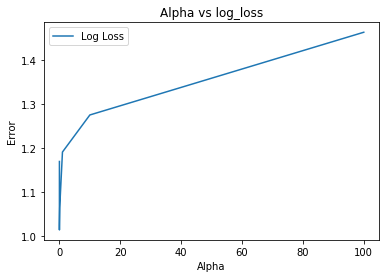

Best alpha is  0.001


In [318]:
alpha = [10**x for x in range(-5,3)]

error = []
for i in alpha:
    sgd = SGDClassifier(alpha=i, loss="log", penalty="l2")
    sgd.fit(train_final_onehot_encoding, y_train)
    clf = CalibratedClassifierCV(sgd, method="sigmoid")
    clf.fit(train_final_onehot_encoding, y_train)

    pred = clf.predict_proba(cv_final_onehot_encoding)
    loss = log_loss(y_cv, pred)
    error.append(loss)
    print("log loss for alpha {} is {}".format(i,loss))
    

#Plotting log loss
plt.plot(alpha, error, label="Log Loss")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.title("Alpha vs log_loss")
plt.legend()
plt.show()

best_alpha = alpha[error.index(min(error))]
print("Best alpha is ", best_alpha)

<h4>4.4.2] Training model with best hyperparameter</h4>

Log Loss on Test data is : 1.2732151550331372
0.3669% of points are miss-classified
************************************************** COnfusion Matrix **************************************************


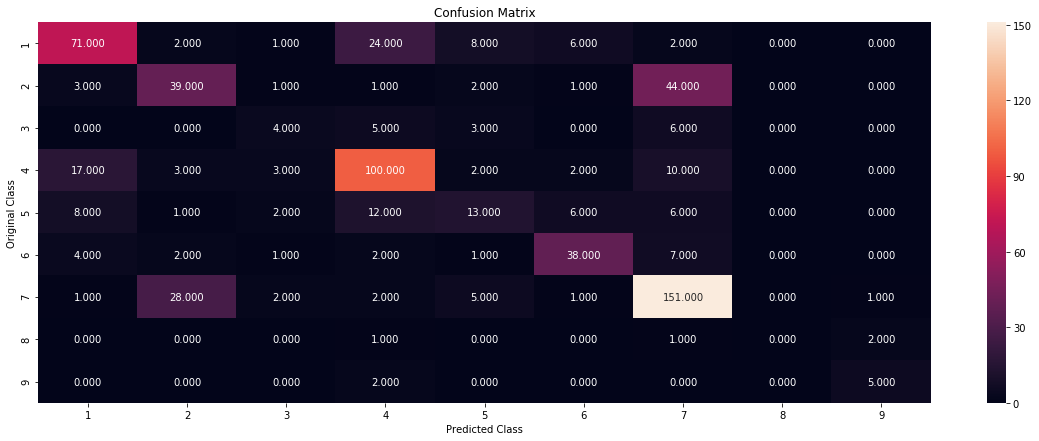

************************************************** Precision Matrix **************************************************


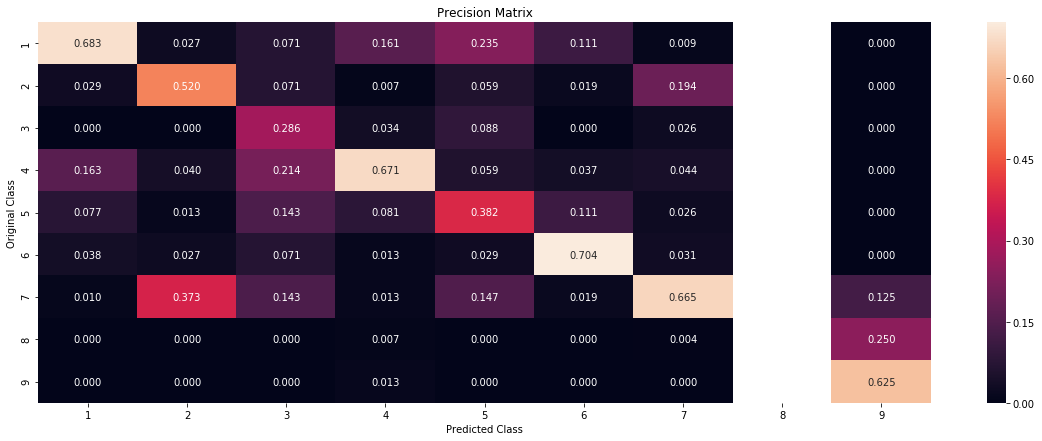

************************************************** Recall Matrix **************************************************


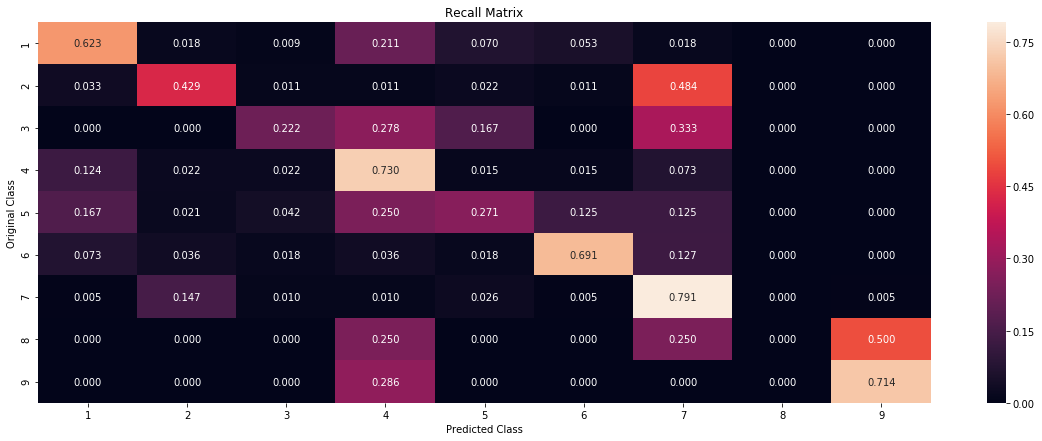

In [319]:
sgd = SGDClassifier(alpha=best_alpha, loss="log", penalty="l2")
sgd.fit(train_final_onehot_encoding, y_train)
clf = CalibratedClassifierCV(sgd, method="sigmoid")
clf.fit(train_final_onehot_encoding, y_train)

# Predicting on test data
pred = clf.predict(test_final_onehot_encoding)
predict_prob = clf.predict_proba(test_final_onehot_encoding)
loss = log_loss(y_test, pred_prob)
miss_classified_points = np.round((np.count_nonzero(pred-y_test)/len(y_test)),4)

print("Log Loss on Test data is :", loss)
print("{}% of points are miss-classified".format(miss_classified_points))

plot_confusion_matrix(y_test, pred)

<h4>4.4.3] Feature Importance on correctly classified points</h4>

In [324]:
test_point_index = 1
no_feature = 500
predicted_cls = clf.predict(train_final_onehot_encoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(clf.predict_proba(test_final_onehot_encoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-sgd.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.075  0.1473 0.0125 0.1667 0.0222 0.0362 0.5297 0.0054 0.005 ]]
Actual Class : 6
--------------------------------------------------
72 Text feature [continues] present in test data point [True]
163 Text feature [achieved] present in test data point [True]
178 Text feature [balanced] present in test data point [True]
193 Text feature [fat] present in test data point [True]
217 Text feature [months] present in test data point [True]
230 Text feature [rearrangements] present in test data point [True]
261 Text feature [roberts] present in test data point [True]
278 Text feature [fusion] present in test data point [True]
279 Text feature [partner] present in test data point [True]
307 Text feature [treatment] present in test data point [True]
315 Text feature [patients] present in test data point [True]
321 Text feature [advanced] present in test data point [True]
359 Text feature [chimera] present in test data point [True]
367 Text feat

<h4>4.4.4] Feature Importance on in-correctly classified points</h4>

In [325]:
test_point_index = 4
no_feature = 500
predicted_cls = clf.predict(train_final_onehot_encoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(clf.predict_proba(test_final_onehot_encoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(sgd.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0078 0.0041 0.0031 0.9717 0.0054 0.002  0.0015 0.0029 0.0015]]
Actual Class : 4
--------------------------------------------------
101 Text feature [activating] present in test data point [True]
104 Text feature [inhibitor] present in test data point [True]
119 Text feature [harbor] present in test data point [True]
121 Text feature [harboring] present in test data point [True]
135 Text feature [soft] present in test data point [True]
136 Text feature [activation] present in test data point [True]
142 Text feature [kinase] present in test data point [True]
144 Text feature [effective] present in test data point [True]
146 Text feature [transform] present in test data point [True]
151 Text feature [agar] present in test data point [True]
156 Text feature [selective] present in test data point [True]
159 Text feature [constitutive] present in test data point [True]
162 Text feature [mitogen] present in test data point [True]
168 Text

###  4.5 ] Linear SVM Model with Class Balancing

<h4>4.5.1] Hyper-parameter tuning of model</h4>

log loss for alpha 1e-05 is 1.2139374768740028
log loss for alpha 0.0001 is 1.1999334791943335
log loss for alpha 0.001 is 1.1067954162286286
log loss for alpha 0.01 is 1.134360163796162
log loss for alpha 0.1 is 1.1606784001842012
log loss for alpha 1 is 1.1444193712420896
log loss for alpha 10 is 1.4534269830433613
log loss for alpha 100 is 1.4524608378468316


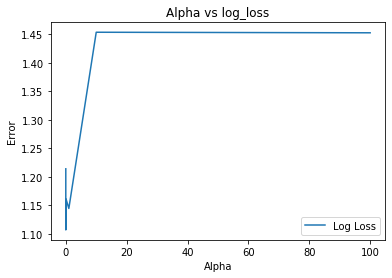

Best alpha is  0.001


In [326]:
alpha = [10**x for x in range(-5,3)]

error = []
for i in alpha:
    sgd = SGDClassifier(alpha=i, loss="hinge", penalty="l2", class_weight="balanced", random_state=0)
    sgd.fit(train_final_onehot_encoding, y_train)
    clf = CalibratedClassifierCV(sgd, method="sigmoid")
    clf.fit(train_final_onehot_encoding, y_train)

    pred = clf.predict_proba(cv_final_onehot_encoding)
    loss = log_loss(y_cv, pred)
    error.append(loss)
    print("log loss for alpha {} is {}".format(i,loss))
    

#Plotting log loss
plt.plot(alpha, error, label="Log Loss")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.title("Alpha vs log_loss")
plt.legend()
plt.show()

best_alpha = alpha[error.index(min(error))]
print("Best alpha is ", best_alpha)

<h4>4.4.2] Training model with best hyperparameter</h4>

Log Loss on Test data is : 1.2732151550331372
36.5414% of points are miss-classified
************************************************** COnfusion Matrix **************************************************


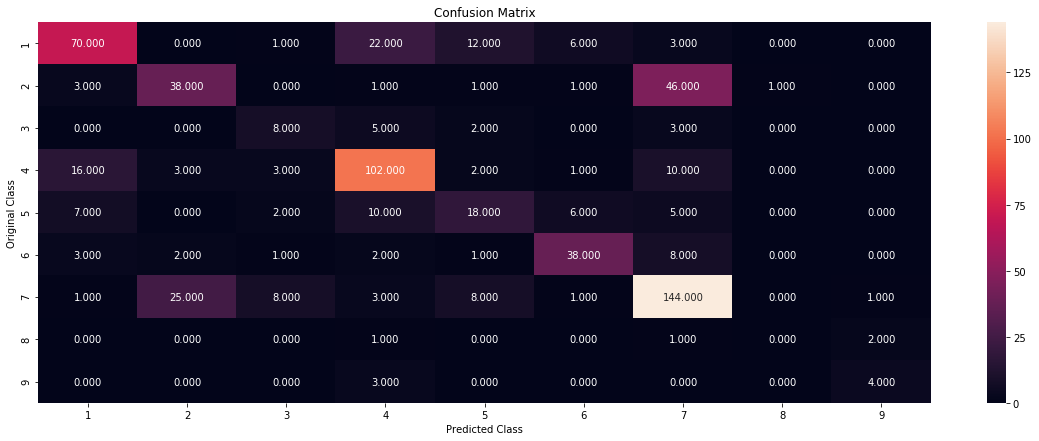

************************************************** Precision Matrix **************************************************


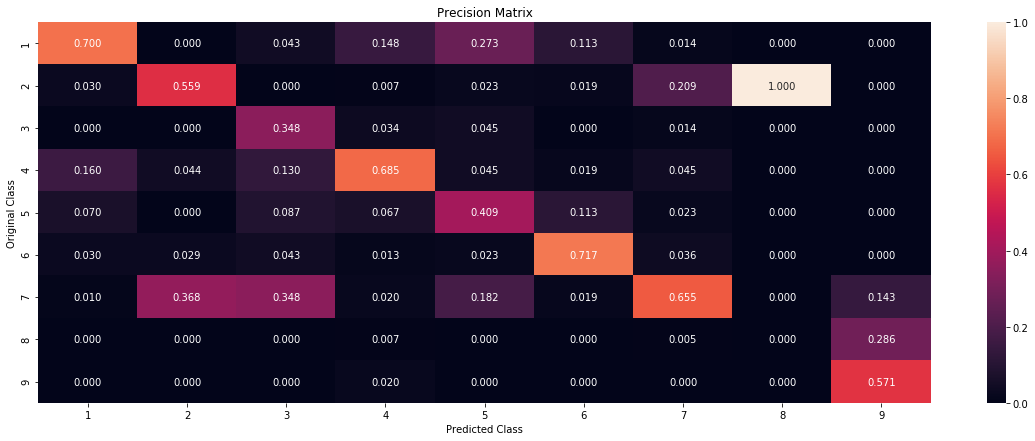

************************************************** Recall Matrix **************************************************


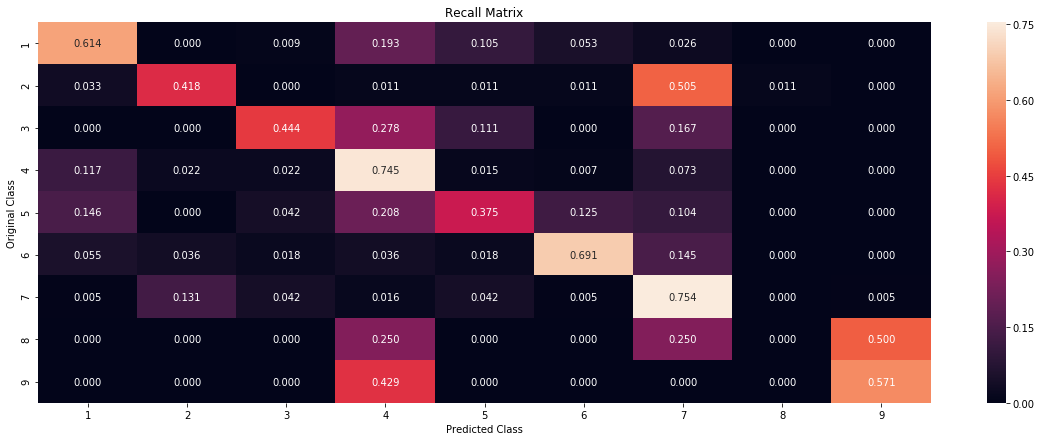

In [339]:
sgd = SGDClassifier(alpha=best_alpha, loss="hinge", penalty="l2", class_weight="balanced")
sgd.fit(train_final_onehot_encoding, y_train)
clf = CalibratedClassifierCV(sgd, method="sigmoid")
clf.fit(train_final_onehot_encoding, y_train)

# Predicting on test data
pred = clf.predict(test_final_onehot_encoding)
predict_prob = clf.predict_proba(test_final_onehot_encoding)
loss = log_loss(y_test, pred_prob)
miss_classified_points = np.round((np.count_nonzero(pred-y_test)*100/len(y_test)),4)

print("Log Loss on Test data is :", loss)
print("{}% of points are miss-classified".format(miss_classified_points))

plot_confusion_matrix(y_test, pred)

<h4>4.4.3] Feature Importance on correctly classified points</h4>

In [311]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [349]:
test_point_index = 112
no_feature = 500
predicted_cls = clf.predict(train_final_onehot_encoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(clf.predict_proba(test_final_onehot_encoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-sgd.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.2306 0.0592 0.0132 0.5256 0.0364 0.0145 0.1134 0.0037 0.0034]]
Actual Class : 1
--------------------------------------------------
398 Text feature [duplex] present in test data point [True]
415 Text feature [interpreted] present in test data point [True]
Out of the top  500  features  2 are present in query point


<h4>4.4.4] Feature Importance on in-correctly classified points</h4>

In [350]:
test_point_index = 1
no_feature = 500
predicted_cls = clf.predict(train_final_onehot_encoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(clf.predict_proba(test_final_onehot_encoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-sgd.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0777 0.1252 0.0177 0.1991 0.0388 0.0462 0.4845 0.0052 0.0057]]
Actual Class : 6
--------------------------------------------------
134 Text feature [balanced] present in test data point [True]
142 Text feature [continues] present in test data point [True]
186 Text feature [roberts] present in test data point [True]
201 Text feature [fat] present in test data point [True]
258 Text feature [qpcr] present in test data point [True]
468 Text feature [achieved] present in test data point [True]
Out of the top  500  features  6 are present in query point


###  4.6 ] Random Forest Model

<h4>4.6.1] Hyper-parameter tuning of model</h4>

In [370]:
from sklearn.ensemble import RandomForestClassifier
n_estimators = (100,200,500,1000, 2000)
max_depth = (5,10,15)

params = tuple((x,y) for x in n_estimators for y in max_depth)
error = [[],[]]

for i in params:
    rf = RandomForestClassifier(n_estimators = i[0], max_depth= i[1], random_state=0)
    rf.fit(train_final_response_encoding, y_train)
    clf = CalibratedClassifierCV(rf, method="sigmoid")
    clf.fit(train_final_response_encoding, y_train)
    
    train_pred = clf.predict_proba(train_final_response_encoding)
    train_loss = log_loss(y_train, train_pred)
    pred = clf.predict_proba(cv_final_response_encoding)
    loss = log_loss(y_cv, pred)
    error[0].append(loss)
    error[1].append(train_loss)
    print("For max_depth of {} and N_estimators being {} the log loss is {}".format(i[1], i[0], loss))
    

best_param = params[error[0].index(min(error[0]))]

print("_"*50)
print(f"The best params are (n_estimators : {best_param[1]},   max_depth : {best_param[0]})")
 
print("The Log loss on Train data for best param is : ", error[1][error[0].index(min(error[0]))])

print("The loss loss on CV data for best param is : ", min(error[0]))

For max_depth of 5 and N_estimators being 100 the log loss is 0.07509456412256904
For max_depth of 10 and N_estimators being 100 the log loss is 0.05016781129172372
For max_depth of 15 and N_estimators being 100 the log loss is 0.04892839928676101
For max_depth of 5 and N_estimators being 200 the log loss is 0.07126527238893064
For max_depth of 10 and N_estimators being 200 the log loss is 0.05073775086822066
For max_depth of 15 and N_estimators being 200 the log loss is 0.0486128286244392
For max_depth of 5 and N_estimators being 500 the log loss is 0.06927931073125841
For max_depth of 10 and N_estimators being 500 the log loss is 0.05035342035932711
For max_depth of 15 and N_estimators being 500 the log loss is 0.04905229354981718
For max_depth of 5 and N_estimators being 1000 the log loss is 0.06848435219397173
For max_depth of 10 and N_estimators being 1000 the log loss is 0.05023863072512541
For max_depth of 15 and N_estimators being 1000 the log loss is 0.04938384869113178
For ma

<h4>4.6.2] Tarining model with best hyper-parameter</h4>

The Log loss on test data is :  0.08722351633740105
The Log loss on train data is :  0.03412425844746979
************************************************** COnfusion Matrix **************************************************


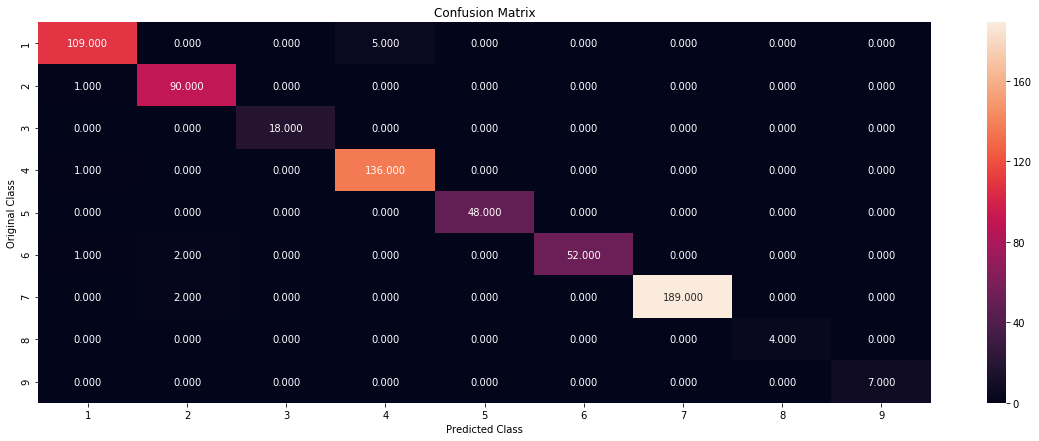

************************************************** Precision Matrix **************************************************


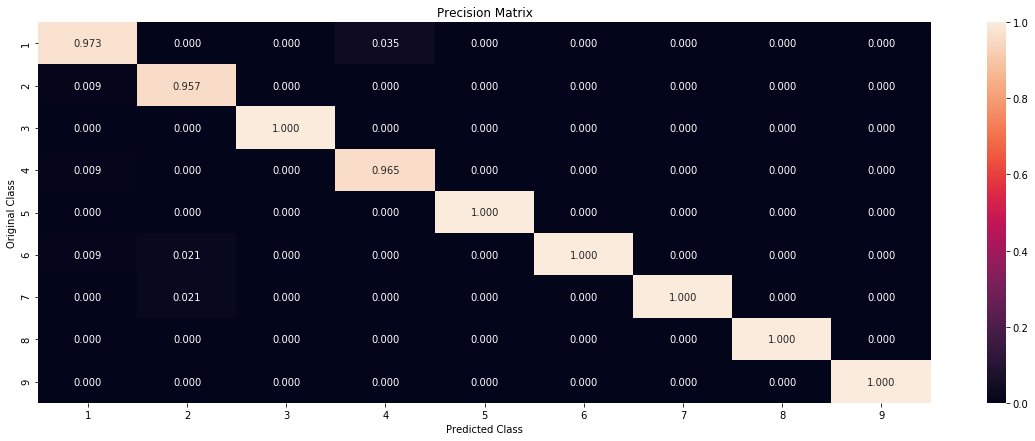

************************************************** Recall Matrix **************************************************


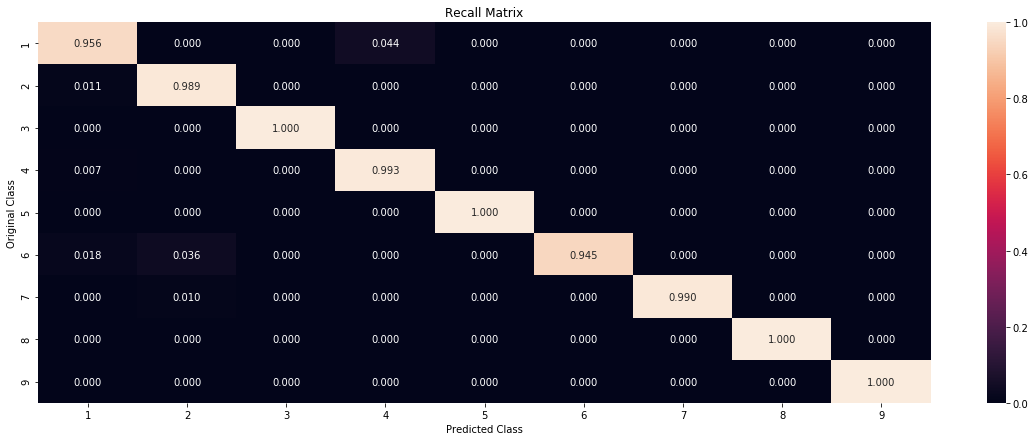

In [401]:
rf = RandomForestClassifier(n_estimators=best_param[1], max_depth=best_param[0], random_state=0)
rf.fit(train_final_response_encoding, y_train)
clf = CalibratedClassifierCV(rf, method="sigmoid")
clf.fit(train_final_response_encoding, y_train)

# predicting on test data
pred = clf.predict(test_final_response_encoding)
pred_prob = clf.predict_proba(test_final_response_encoding)
loss = log_loss(y_test, pred_prob)
print("The Log loss on test data is : ", loss)

# predicting on train data
pred_prob = clf.predict_proba(train_final_response_encoding)
loss = log_loss(y_train, pred_prob)
print("The Log loss on train data is : ", loss)

# confusion Matrix
plot_confusion_matrix(y_test, pred)

<h4>4.5.3] Feature Importance on correctly classified points</h4>

In [399]:
test_point_index = 1
top_features = 100

y_pred = clf.predict(test_final_response_encoding[test_point_index].reshape(1,-1))
y_true = X_test.Class.iloc[test_point_index]
y_prob = clf.predict_proba(test_final_response_encoding[test_point_index].reshape(1,-1))

print("Actual Class :", y_true)
print("Predicted Class: ", y_pred[0])
print("Probablities : ", np.round(y_prob[0],4))

imp_feature_indices = np.argsort(-rf.feature_importances_)
print(imp_feature_indices)
print()
for i in imp_feature_indices:
    if i < 9:
        print("Gene Feature is important")
    elif i<18:
        print("Variation Feature is important")
    else:
        print("Text Feature is important")


    
        

Actual Class : 6
Predicted Class:  2
Probablities :  [0.0297 0.6421 0.0047 0.0092 0.0046 0.0341 0.2584 0.0127 0.0043]
[15  9 12 10 13 14 24 21  3 18 11 19  6 23  1  5 22  4 20  8  0 26 17  7
 16  2 25]

Variation Feature is important
Variation Feature is important
Variation Feature is important
Variation Feature is important
Variation Feature is important
Variation Feature is important
Text Feature is important
Text Feature is important
Gene Feature is important
Text Feature is important
Variation Feature is important
Text Feature is important
Gene Feature is important
Text Feature is important
Gene Feature is important
Gene Feature is important
Text Feature is important
Gene Feature is important
Text Feature is important
Gene Feature is important
Gene Feature is important
Text Feature is important
Variation Feature is important
Gene Feature is important
Variation Feature is important
Gene Feature is important
Text Feature is important


#  Final Conclusion:

<h3>1] Feature Analysis:</h3>

When feature analysis was done the most important feature was founded as Text which is followed by Gene and then Variation which was also found to be a bit unstable but still useful as it contributed in reducing log loss.


<br>

<h3>2] Feature Engineering:</h3>

i)<b> Gene</b> - In Gene the number of unique values were very high, hence which eventually lead to decision that there is need of some smart feature engineering like replacing each value with its probablity with each class, and the other technique used is 
traditional one i.e creating dummy variables.

ii) <b>Variation</b> - Same techniques were used as used for Gene feature.

iii) <b>Text</b> - The traditional one used ws Tf-Idf featurization, and the other one was similar to gene's featurization. The probablity of each word was calculated wrt to each class, and for each sentence all the probablities were added.

<br>



<h3>3] ML Models : </h3> <br> In modelling phase various models we tried and the results were observed. The models are as follows

i) <b>Naive Bayes</b> - Now we all know that Naive Bayes is standard algorithm or said to be as best model when working with text data. But in this case the results were speaking differently. Although the log loss of naive bayes model was small, but looking at precision and confusion matrix, it cab be concluded that the minority classes were predicted wrongly like 8 and 9.
So Naive Bayes was ruled out.

ii) <b>KNN</b> - Suprisingly even though we had higher dimensional data knn worked beyond expectations and showed some fabulous results , like giving imporatnce to minority class and predicting them rightly.

iii) <b> Logistic Regression </b> - LR was tried with both class balancing and witout class balancing but results were poor.

iv) <b>Linear SVM</b> - Linear SVM's performance weren't different from Logistic regression.

v) <b>Random Forest</b> - For Random Forest the data used was response encoded as RF works well with lower dimensions. And random forest kept the expectations . It showed the best results.

<br>

<h3>4] Best Model</h3>

After observing all the results , the  best model for this case study is <p style="color:red">Random Forest with response encoding


